# Section One: Import libraries and set up

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
import seaborn as sb

import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import optuna

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Section Two: Data Exploration

Read in raw data, named `credit_raw` and `application_raw` respectively.

In [3]:
# Change the directory to the path where the datasets are located
credit_raw = pd.read_csv("../data/credit_record.csv")
application_raw = pd.read_csv("../data/application_record.csv")

## Explore the `credit_raw` data

In [4]:
credit_raw.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### Data shape

In [5]:
credit_raw.shape

(1048575, 3)

### Data Description

In [6]:
credit_raw.describe(include = "all")

,ID,MONTHS_BALANCE,STATUS
count,1048575.00,1048575.00,1048575
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,442031
mean,5068286.42,-19.14,NaN
std,46150.58,14.02,NaN
min,5001711.00,-60.00,NaN
25%,5023644.00,-29.00,NaN
50%,5062104.00,-17.00,NaN
75%,5113856.00,-7.00,NaN


### Data type

- `STATUS` may need to be changed into categorical type?

In [7]:
credit_raw.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

In [8]:
np.unique(credit_raw["STATUS"])

array(['0', '1', '2', '3', '4', '5', 'C', 'X'], dtype=object)

### Missing value

In [9]:
for column in credit_raw.columns:
    null_count = credit_raw[column].isnull().sum()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} null values.")

## Explore `application_raw`

In [10]:
application_raw.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
1,5008805,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
2,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00
3,5008808,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00
4,5008809,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00


### Data shape

In [11]:
application_raw.shape

(438557, 18)

In [12]:
application = application_raw.copy()

#### Rename columns

In [13]:
application.columns = ['ID',
 'GENDER',
 'CAR',
 'REALTY',
 'CNT_CHILDREN',
 'INCOME_TOTAL',
 'INCOME_TYPE',
 'EDUCATION_TYPE',
 'FAMILY_STATUS',
 'HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBILE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS']

#### Numerical description of features

- `CNT_CHILDREN`, `CNT_FAM_MEMBERS` -- outliers
- `DAYS_EMPLOYED` -- 365234, might be missing value
- `FLAG_MOBIL` -- 0,1 cat
- `OCCUPATION_TYPE` -- too many categories

In [14]:
application.describe(include="all")

,ID,GENDER,CAR,REALTY,CNT_CHILDREN,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBILE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
count,438557.00,438557,438557,438557,438557.00,438557.00,438557,438557,438557,438557,438557.00,438557.00,438557.00,438557.00,438557.00,438557.00,304354,438557.00
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN
freq,NaN,294440,275459,304074,NaN,NaN,226104,301821,299828,393831,NaN,NaN,NaN,NaN,NaN,NaN,78240,NaN
mean,6022176.27,NaN,NaN,NaN,0.43,187524.29,NaN,NaN,NaN,NaN,-15997.90,60563.68,1.00,0.21,0.29,0.11,NaN,2.19
std,571637.02,NaN,NaN,NaN,0.72,110086.85,NaN,NaN,NaN,NaN,4185.03,138767.80,0.00,0.40,0.45,0.31,NaN,0.90
min,5008804.00,NaN,NaN,NaN,0.00,26100.00,NaN,NaN,NaN,NaN,-25201.00,-17531.00,1.00,0.00,0.00,0.00,NaN,1.00
25%,5609375.00,NaN,NaN,NaN,0.00,121500.00,NaN,NaN,NaN,NaN,-19483.00,-3103.00,1.00,0.00,0.00,0.00,NaN,2.00
50%,6047745.00,NaN,NaN,NaN,0.00,160780.50,NaN,NaN,NaN,NaN,-15630.00,-1467.00,1.00,0.00,0.00,0.00,NaN,2.00
75%,6456971.00,NaN,NaN,NaN,1.00,225000.00,NaN,NaN,NaN,NaN,-12514.00,-371.00,1.00,0.00,1.00,0.00,NaN,3.00


#### Missing values

In [15]:
for column in application.columns:
    null_count = application[column].isnull().sum()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} null values.")

Column 'OCCUPATION_TYPE' has 134203 null values.


# Section Three: Data Processing

## Data processing on `application_raw` dataset

#### `GENDER` column

##### Plot bar graph to check categories

Text(0.5, 1.0, 'Bar Graph of GENDER Column')

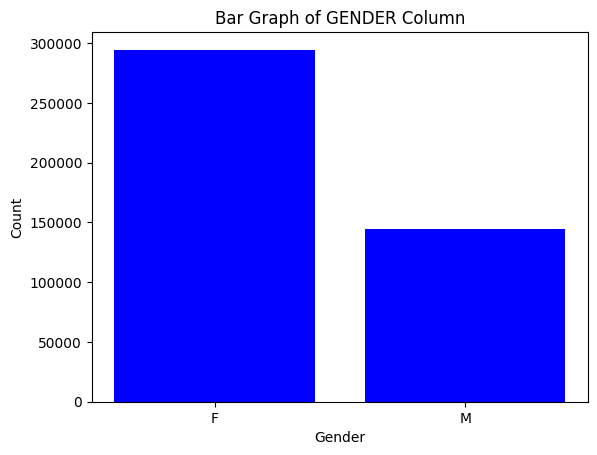

In [16]:
counts_gender = application['GENDER'].value_counts().reset_index()
counts_gender.columns = ['Gender', 'Count']

plt.bar(counts_gender['Gender'], counts_gender['Count'], color='blue')

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Bar Graph of GENDER Column')

##### Change data of GENDER from string to numerical values

In [17]:
application['GENDER'] = application['GENDER'].replace({'F': 1, 'M': 0})

application['GENDER'].value_counts()

GENDER
1    294440
0    144117
Name: count, dtype: int64

#### `CAR` column

##### Plot bar graph to check categories

Text(0.5, 1.0, 'Bar Graph of CAR Column')

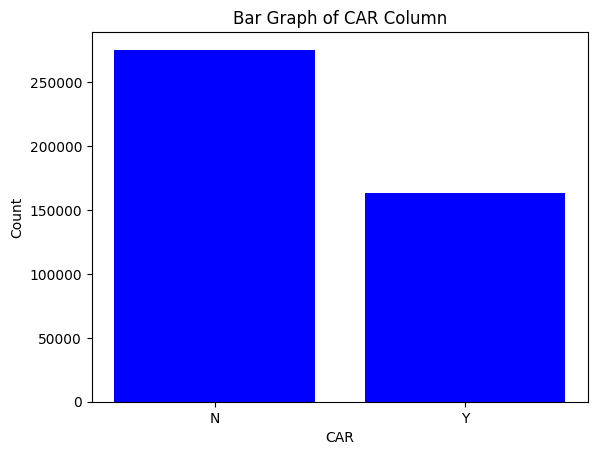

In [18]:
counts_car = application['CAR'].value_counts().reset_index()
counts_car.columns = ['Car', 'Count']

plt.bar(counts_car['Car'], counts_car['Count'], color='blue')

plt.xlabel('CAR')
plt.ylabel('Count')
plt.title('Bar Graph of CAR Column')

##### Change data of CAR from string to numerical values

In [19]:

application['CAR'] = application['CAR'].replace({'Y': 1, 'N': 0})

application['CAR'].value_counts()

CAR
0    275459
1    163098
Name: count, dtype: int64

#### `REALTY` column

##### Plot bar graph to check categories

Text(0.5, 1.0, 'Bar Graph of REALTY Column')

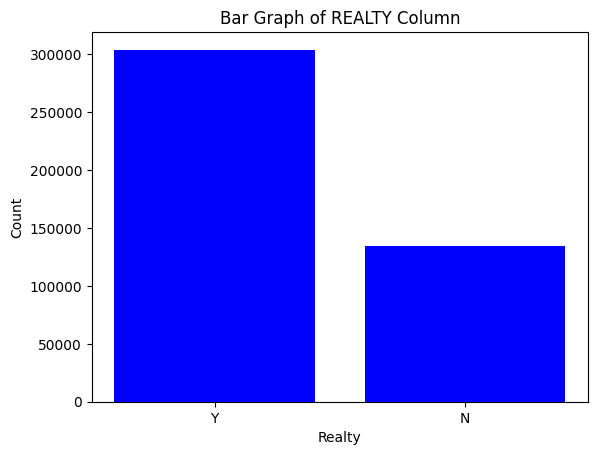

In [20]:
counts_realty = application['REALTY'].value_counts().reset_index()
counts_realty.columns = ['Realty', 'Count']

plt.bar(counts_realty['Realty'], counts_realty['Count'], color='blue')

plt.xlabel('Realty')
plt.ylabel('Count')
plt.title('Bar Graph of REALTY Column')

##### Change data of REALTY from string to numerical values

In [21]:
application['REALTY'] = application['REALTY'].replace({'Y': 1, 'N': 0})

application['REALTY'].value_counts()

REALTY
1    304074
0    134483
Name: count, dtype: int64

#### `CNT_CHILDREN` column

##### Plot box plot to see the distribution of numerical values

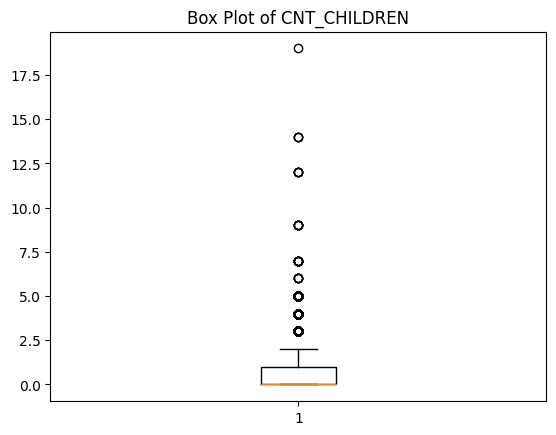

In [22]:
plt.boxplot(application["CNT_CHILDREN"])

plt.title('Box Plot of CNT_CHILDREN')
plt.show()

##### Plot histgram to see the distribution

Text(0.5, 1.0, 'Histgram of CNT_CHILDREN Column')

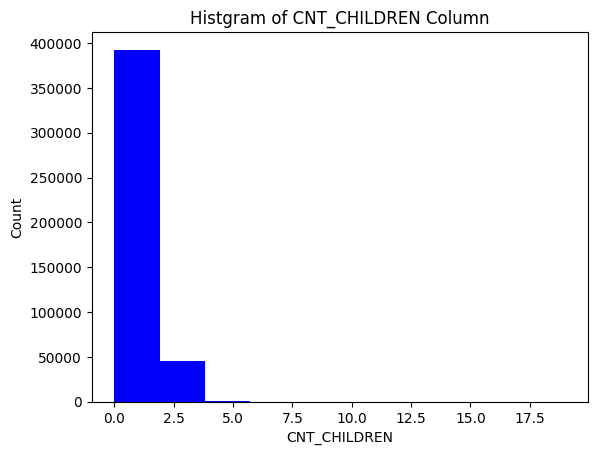

In [23]:
plt.hist(application['CNT_CHILDREN'], color='blue')

plt.xlabel('CNT_CHILDREN')
plt.ylabel('Count')
plt.title('Histgram of CNT_CHILDREN Column')

##### Dealing with outliers

- Minimize the effects of outlier by Winsorization.
- According to Interquartile Range (IQR) Method, the numbers ourside range [-1.5, 2.5] are outliers.
- Replacing values above 2.5 with 2

In [24]:
Q1_child = np.percentile(application['CNT_CHILDREN'], 25)
Q3_child = np.percentile(application['CNT_CHILDREN'], 75)
IQR_child = Q3_child - Q1_child
up_child = Q3_child + 1.5 * IQR_child
low_child = Q1_child - 1.5 * IQR_child
print(up_child, low_child)

2.5 -1.5


In [25]:
application.loc[application['CNT_CHILDREN'] >= 3,'CNT_CHILDREN'] = 2
print(application['CNT_CHILDREN'].value_counts(sort=False))

CNT_CHILDREN
0    304071
1     88527
2     45959
Name: count, dtype: int64


#### `CNT_FAM_MEMBER` column

##### Plot box plot to see the distribution of numerical values

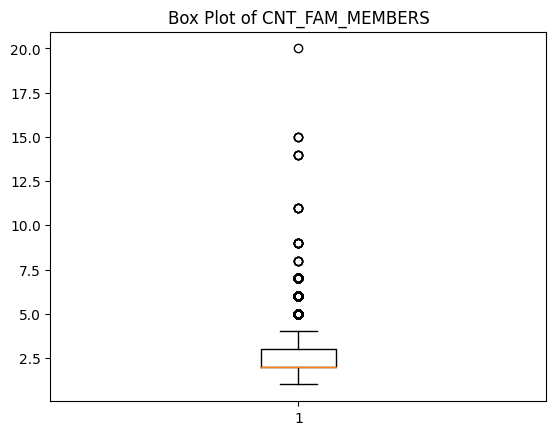

In [26]:
plt.boxplot(application["CNT_FAM_MEMBERS"])

plt.title('Box Plot of CNT_FAM_MEMBERS')
plt.show()

##### Dealing with outliers

- Minimize the effects of outlier by Winsorization.
- According to Interquartile Range (IQR) Method, the numbers ourside range [0.5, 4.5] are outliers.
- Replacing values above 4.5 with 4

In [27]:
Q1_fam = np.percentile(application['CNT_FAM_MEMBERS'], 25)
Q3_fam = np.percentile(application['CNT_FAM_MEMBERS'], 75)
IQR_fam = Q3_fam - Q1_fam
up_fam = Q3_fam + 1.5 * IQR_fam
low_fam = Q1_fam - 1.5 * IQR_fam
print(up_fam, low_fam)

4.5 0.5


In [28]:
application.loc[application['CNT_FAM_MEMBERS'] >= 5,'CNT_FAM_MEMBERS'] = 4
print(application['CNT_FAM_MEMBERS'].value_counts(sort=False))

CNT_FAM_MEMBERS
2.00    233891
1.00     84492
4.00     43046
3.00     77128
Name: count, dtype: int64


#### `INCOME_TOTAL` column

##### Plot histgram to see the distribution

Text(0.5, 1.0, 'Histgram of INCOME_TOTAL Column')

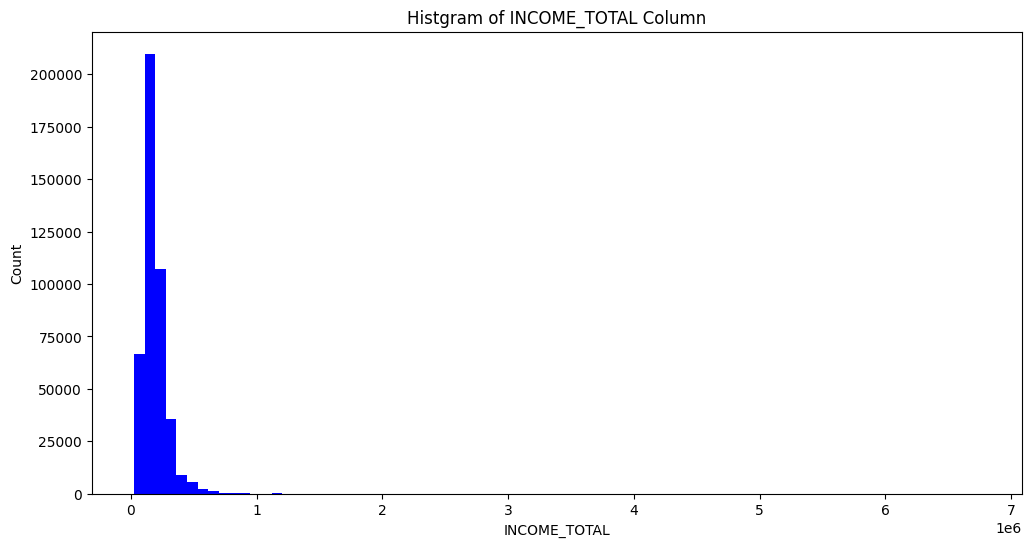

In [29]:
plt.figure(figsize=(12, 6))

plt.hist(application['INCOME_TOTAL'], bins = 80, color='blue')

plt.xlabel('INCOME_TOTAL')
plt.ylabel('Count')
plt.title('Histgram of INCOME_TOTAL Column')

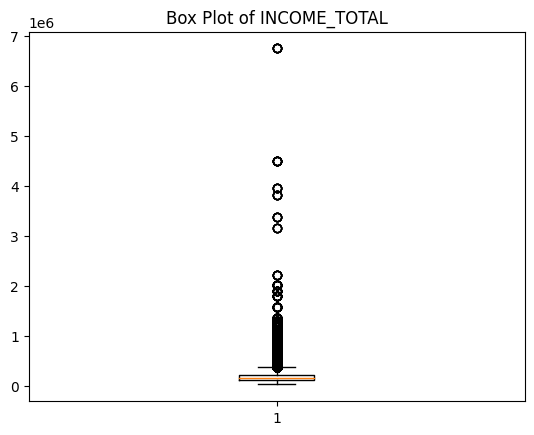

In [30]:
plt.boxplot(application["INCOME_TOTAL"])

plt.title('Box Plot of INCOME_TOTAL')
plt.show()

In [31]:
Q1_income = np.percentile(application['INCOME_TOTAL'], 25)
Q3_income = np.percentile(application['INCOME_TOTAL'], 75)
IQR_income = Q3_income - Q1_income
up_income = Q3_income + 1.5 * IQR_income
low_income = Q1_income - 1.5 * IQR_income
print(up_income, low_income)

380250.0 -33750.0


In [32]:
application.loc[application['INCOME_TOTAL'] > 380250.0,'INCOME_TOTAL'] = 380250.0

Text(0.5, 1.0, 'Histgram of INCOME_TOTAL Column')

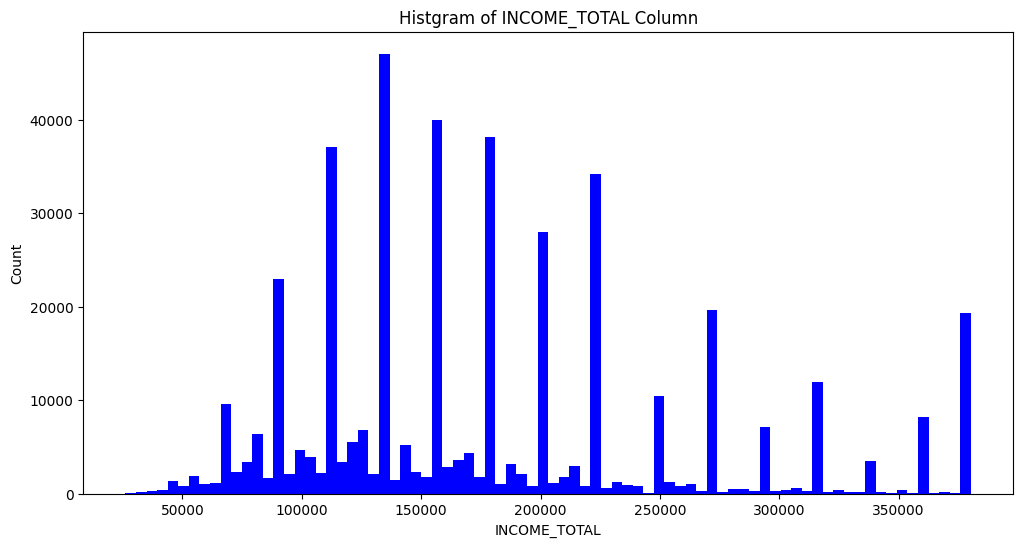

In [33]:
plt.figure(figsize=(12, 6))

plt.hist(application['INCOME_TOTAL'], bins = 80, color='blue')

plt.xlabel('INCOME_TOTAL')
plt.ylabel('Count')
plt.title('Histgram of INCOME_TOTAL Column')

#### `INCOME_TYPE` column

##### Plot bar graph to check the categories

Text(0.5, 1.0, 'Bar Graph of INCOME_TYPE Column')

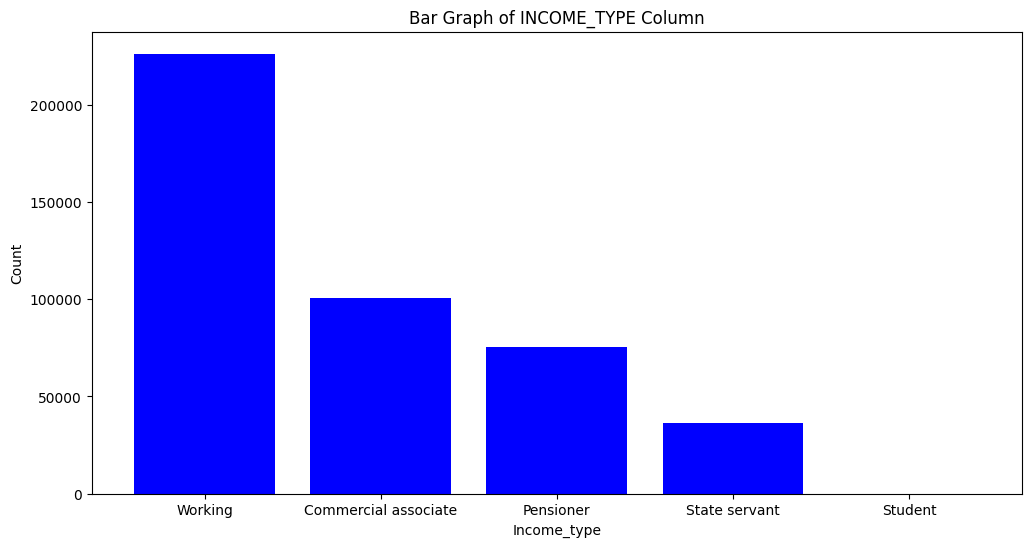

In [34]:
counts_income_type = application['INCOME_TYPE'].value_counts().reset_index()
counts_income_type.columns = ['Income_type', 'Count']

plt.figure(figsize=(12, 6))
plt.bar(counts_income_type['Income_type'], counts_income_type['Count'], color='blue')

plt.xlabel('Income_type')
plt.ylabel('Count')
plt.title('Bar Graph of INCOME_TYPE Column')

#### `EDUCATION_TYPE` column

##### Plot histgram to see the distribution

Text(0.5, 1.0, 'Bar Graph of EDUCATION_TYPE Column')

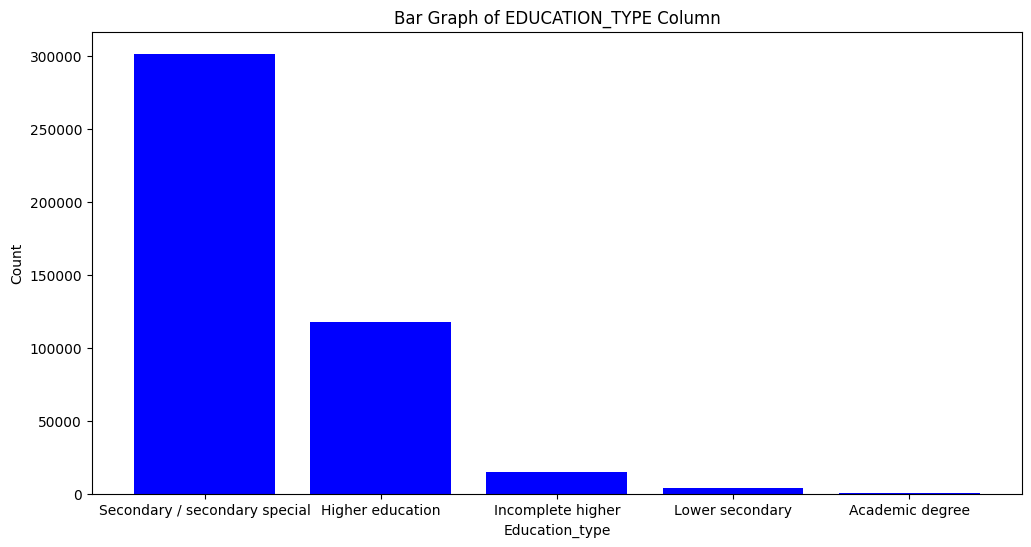

In [35]:
counts_education_type = application['EDUCATION_TYPE'].value_counts().reset_index()
counts_education_type.columns = ['Education_type', 'Count']

plt.figure(figsize=(12, 6))

plt.bar(counts_education_type['Education_type'], counts_education_type['Count'], color='blue')

plt.xlabel('Education_type')
plt.ylabel('Count')
plt.title('Bar Graph of EDUCATION_TYPE Column')

#### `FAMILY_STATUS` column

##### Plot bar graph to check the categories

Text(0.5, 1.0, 'Bar Graph of FAMILY_STATUS Column')

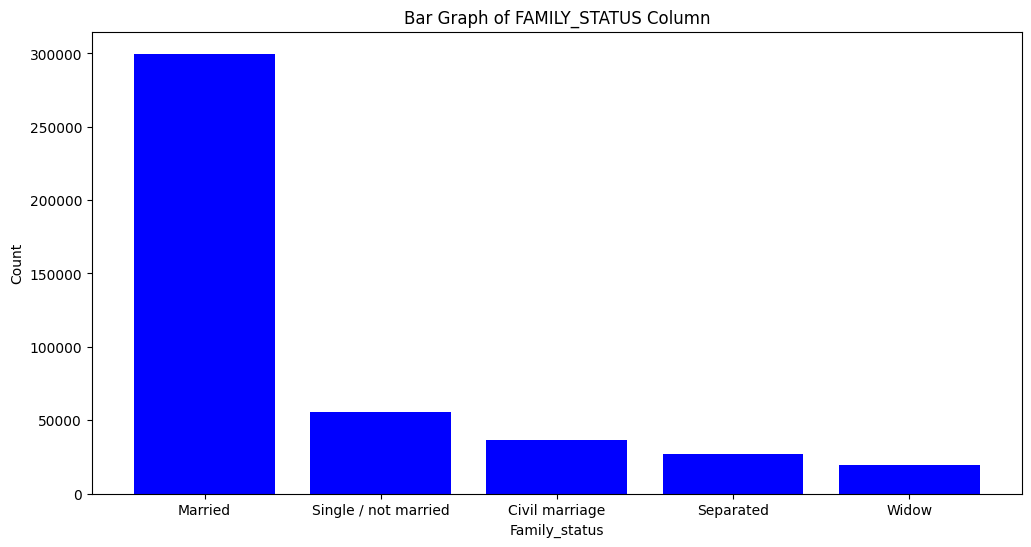

In [36]:
counts_family_status = application['FAMILY_STATUS'].value_counts().reset_index()
counts_family_status.columns = ['Family_status', 'Count']

plt.figure(figsize=(12, 6))

plt.bar(counts_family_status['Family_status'], counts_family_status['Count'], color='blue')

plt.xlabel('Family_status')
plt.ylabel('Count')
plt.title('Bar Graph of FAMILY_STATUS Column')

#### `HOUSING_TYPE` column

##### Plot bar graph to check the categories

Text(0.5, 1.0, 'Bar Graph of HOUSING_TYPE Column')

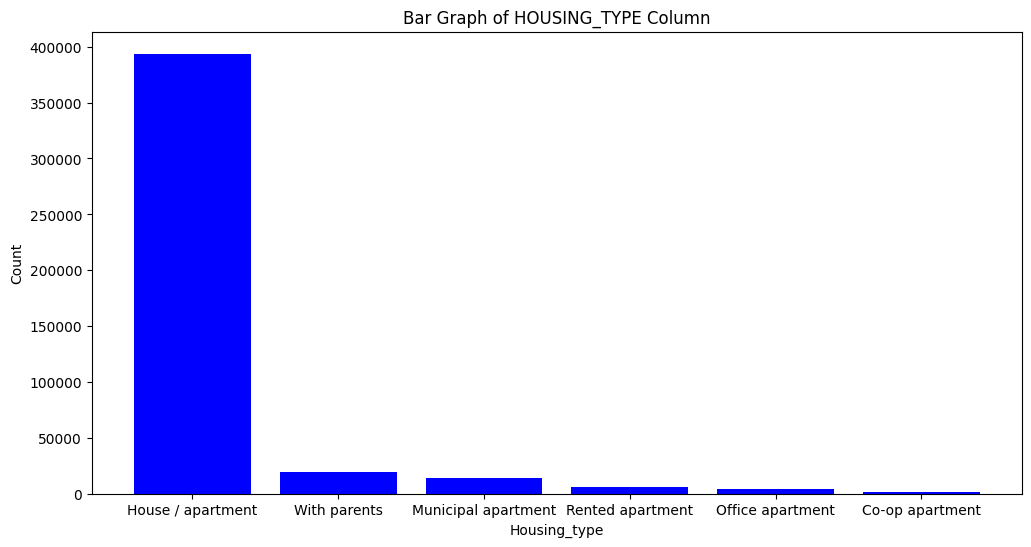

In [37]:
counts_housing_type = application['HOUSING_TYPE'].value_counts().reset_index()
counts_housing_type.columns = ['Housing_type', 'Count']

plt.figure(figsize=(12, 6))

plt.bar(counts_housing_type['Housing_type'], counts_housing_type['Count'], color='blue')

plt.xlabel('Housing_type')
plt.ylabel('Count')
plt.title('Bar Graph of HOUSING_TYPE Column')

#### `DAYS_BIRTH` column

##### Plot histgram to see the distribution

Text(0.5, 1.0, 'Histgram of DAYS_BIRTH Column')

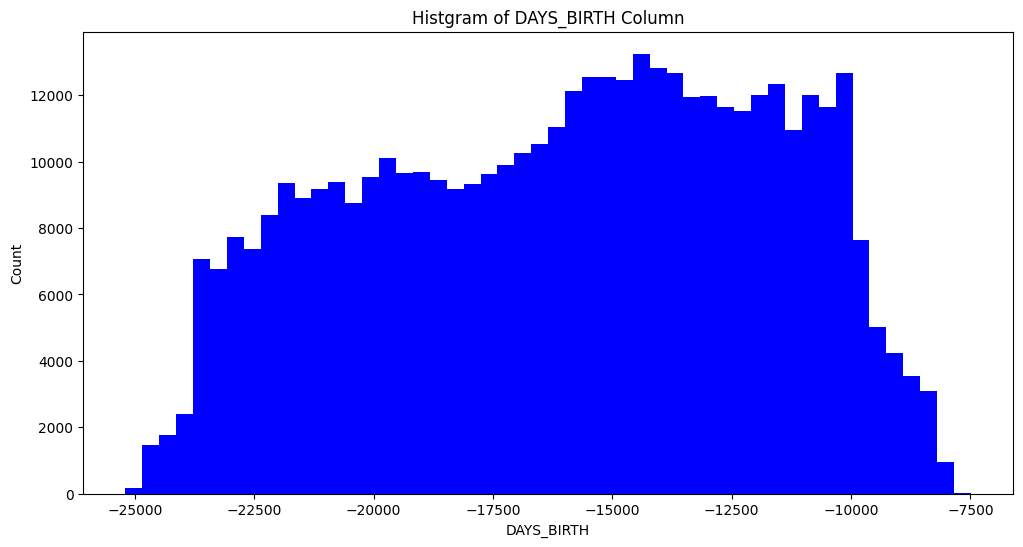

In [38]:
plt.figure(figsize=(12, 6))

plt.hist(application['DAYS_BIRTH'], bins = 50, color='blue')

plt.xlabel('DAYS_BIRTH')
plt.ylabel('Count')
plt.title('Histgram of DAYS_BIRTH Column')

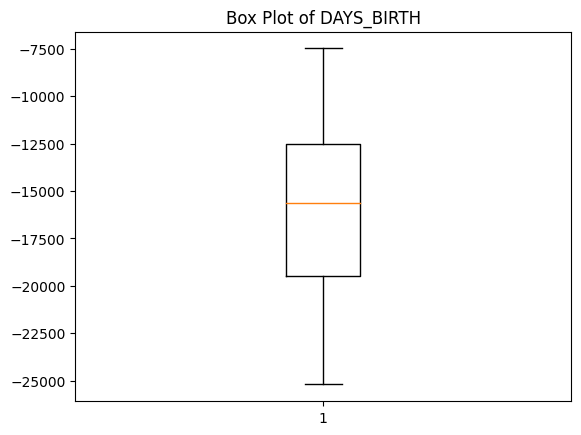

In [39]:
plt.boxplot(application["DAYS_BIRTH"])

plt.title('Box Plot of DAYS_BIRTH')
plt.show()

#### `DAYS_EMPLOYED` column

##### Plot histgram to see the distribution

Text(0.5, 1.0, 'Histgram of DAYS_EMPLOYED Column')

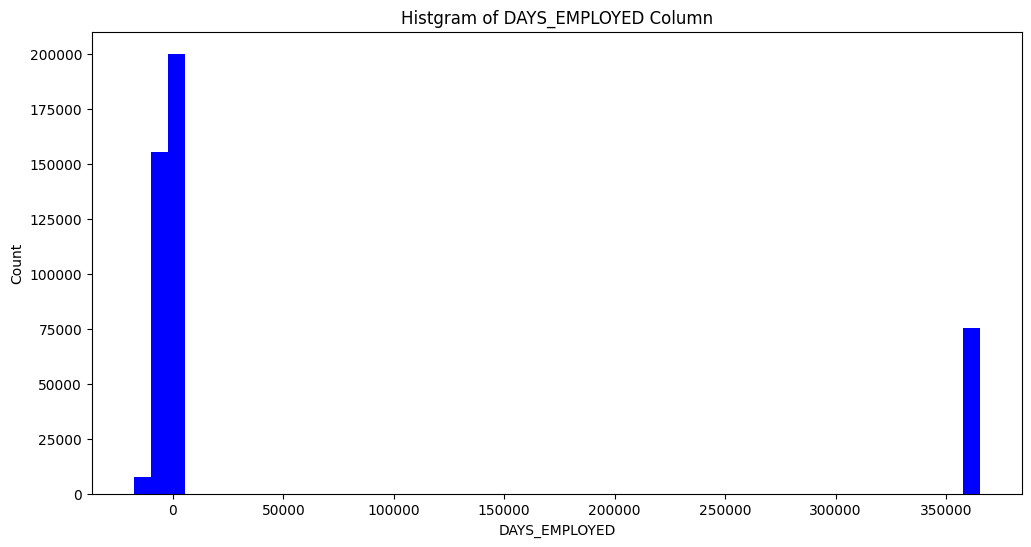

In [40]:
plt.figure(figsize=(12, 6))

plt.hist(application['DAYS_EMPLOYED'], bins = 50, color='blue')

plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.title('Histgram of DAYS_EMPLOYED Column')

##### Dealing with outliers

- The outliers are positive and too big -- 365243
- We suspect that it should be the way to record missing values

In [41]:
application.loc[application['DAYS_EMPLOYED'].isin([365243]), 'DAYS_EMPLOYED'] = np.nan

##### Dealing with skewness

From the graph we could see that the DAYS_EMPLOYED is highly skewed, which could be dealt with using log transformation.

Text(0.5, 1.0, 'Histgram of DAYS_EMPLOYED Column')

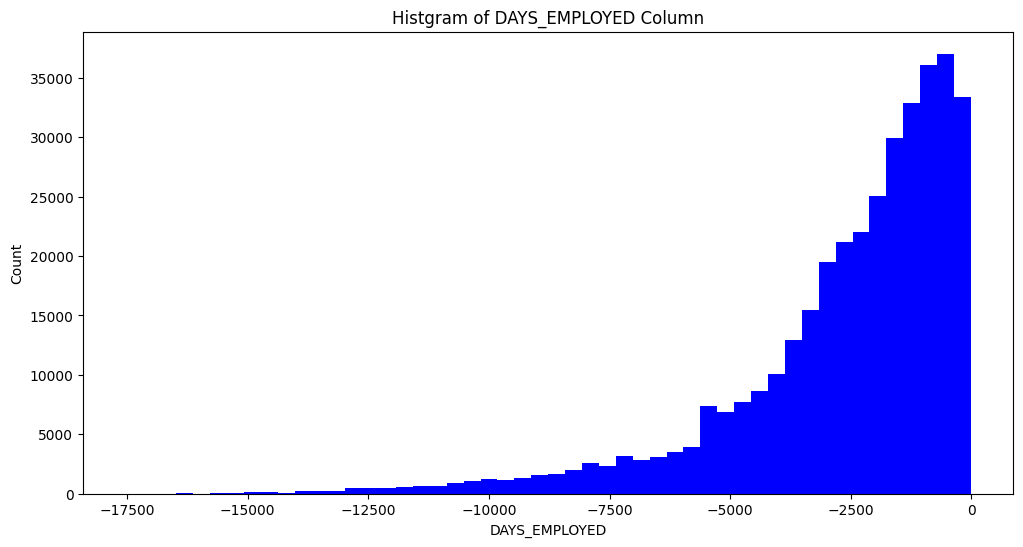

In [42]:
plt.figure(figsize=(12, 6))

plt.hist(application['DAYS_EMPLOYED'], bins = 50, color='blue')

plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.title('Histgram of DAYS_EMPLOYED Column')

In [43]:
min_employed = application['DAYS_EMPLOYED'].min()
application['LOG_DAYS_EMPLOYED'] = application['DAYS_EMPLOYED'].apply(lambda x: np.log(-x))

Text(0.5, 1.0, 'Histgram of LOG_DAYS_EMPLOYED Column')

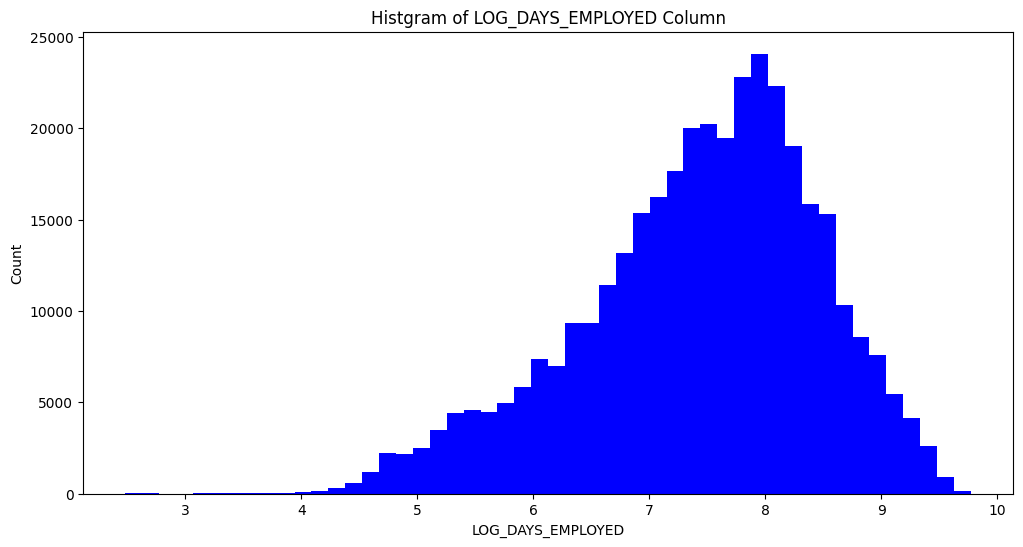

In [44]:
plt.figure(figsize=(12, 6))

plt.hist(application['LOG_DAYS_EMPLOYED'], bins = 50, color='blue')

plt.xlabel('LOG_DAYS_EMPLOYED')
plt.ylabel('Count')
plt.title('Histgram of LOG_DAYS_EMPLOYED Column')

In [45]:
application.drop('DAYS_EMPLOYED', axis=1, inplace=True)

#### Drop `FLAG_MOBILE` column which is 1 for all the data instances

In [46]:
application.drop('FLAG_MOBILE', axis=1, inplace=True)

#### `OCCUPATION_TYPE` column 

##### Recategoriztion

- Since there are 18 categories, we reacategorized the values into more general categories
- Reference: 

In [47]:
application.loc[(application['OCCUPATION_TYPE']=='Cleaning staff') | (application['OCCUPATION_TYPE']=='Cooking staff') | (application['OCCUPATION_TYPE']=='Drivers') | (application['OCCUPATION_TYPE']=='Laborers') | (application['OCCUPATION_TYPE']=='Low-skill Laborers') | (application['OCCUPATION_TYPE']=='Security staff') | (application['OCCUPATION_TYPE']=='Waiters/barmen staff'),'OCCUPATION_TYPE']='Laborwk'
application.loc[(application['OCCUPATION_TYPE']=='Accountants') | (application['OCCUPATION_TYPE']=='Core staff') | (application['OCCUPATION_TYPE']=='HR staff') | (application['OCCUPATION_TYPE']=='Medicine staff') | (application['OCCUPATION_TYPE']=='Private service staff') | (application['OCCUPATION_TYPE']=='Realty agents') | (application['OCCUPATION_TYPE']=='Sales staff') | (application['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE']='officewk'
application.loc[(application['OCCUPATION_TYPE']=='Managers') | (application['OCCUPATION_TYPE']=='High skill tech staff') | (application['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE']='hightecwk'
print(application['OCCUPATION_TYPE'].value_counts())

OCCUPATION_TYPE
Laborwk      130049
officewk     120925
hightecwk     53380
Name: count, dtype: int64


#### Check duplicates

In [48]:
application.duplicated().sum()

0

#### Check for highly correlated variables

In [49]:
OCCUPATION_map = application.groupby(['GENDER', 'EDUCATION_TYPE'])['OCCUPATION_TYPE'].agg(pd.Series.mode)
for i in application.select_dtypes("object").columns:
    print(i,' : ',application[i].unique()) 

INCOME_TYPE  :  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
EDUCATION_TYPE  :  ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
FAMILY_STATUS  :  ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
HOUSING_TYPE  :  ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
OCCUPATION_TYPE  :  [nan 'Laborwk' 'officewk' 'hightecwk']


##### Ordinal encoding

In [50]:
application_cor = application.copy()

application_cor['EDUCATION_TYPE'] = application_cor['EDUCATION_TYPE'].replace({'Higher education': 0, 'Secondary / secondary special': 1, 'Incomplete higher': 2,
 'Lower secondary': 3, 'Academic degree': 4})
application_cor['INCOME_TYPE'] = application_cor['INCOME_TYPE'].replace({'Working': 0, 'Commercial associate': 1, 'Pensioner': 2, 'State servant': 3, 'Student': 4})
application_cor['FAMILY_STATUS'] = application_cor['FAMILY_STATUS'].replace({'Civil marriage': 0, 'Married': 1, 'Single / not married': 2, 'Separated': 3,  'Widow': 4})
application_cor['HOUSING_TYPE'] = application_cor['HOUSING_TYPE'].replace({'Rented apartment': 0, 'House / apartment': 1, 'Municipal apartment': 2,
 'With parents': 3, 'Co-op apartment': 4, 'Office apartment': 5})
application_cor['HOUSING_TYPE'] = application_cor['HOUSING_TYPE'].replace({'Rented apartment': 0, 'House / apartment': 1, 'Municipal apartment': 2,
 'With parents': 3, 'Co-op apartment': 4, 'Office apartment': 5})
application_cor['OCCUPATION_TYPE'] = application_cor['OCCUPATION_TYPE'].replace({'hightecwk': 0, 'Laborwk': 1, 'officewk': 2})

##### Check data types

In [51]:
application_cor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 438557 non-null  int64  
 1   GENDER             438557 non-null  int64  
 2   CAR                438557 non-null  int64  
 3   REALTY             438557 non-null  int64  
 4   CNT_CHILDREN       438557 non-null  int64  
 5   INCOME_TOTAL       438557 non-null  float64
 6   INCOME_TYPE        438557 non-null  int64  
 7   EDUCATION_TYPE     438557 non-null  int64  
 8   FAMILY_STATUS      438557 non-null  int64  
 9   HOUSING_TYPE       438557 non-null  int64  
 10  DAYS_BIRTH         438557 non-null  int64  
 11  FLAG_WORK_PHONE    438557 non-null  int64  
 12  FLAG_PHONE         438557 non-null  int64  
 13  FLAG_EMAIL         438557 non-null  int64  
 14  OCCUPATION_TYPE    304354 non-null  float64
 15  CNT_FAM_MEMBERS    438557 non-null  float64
 16  LO

##### Correlation heatmap

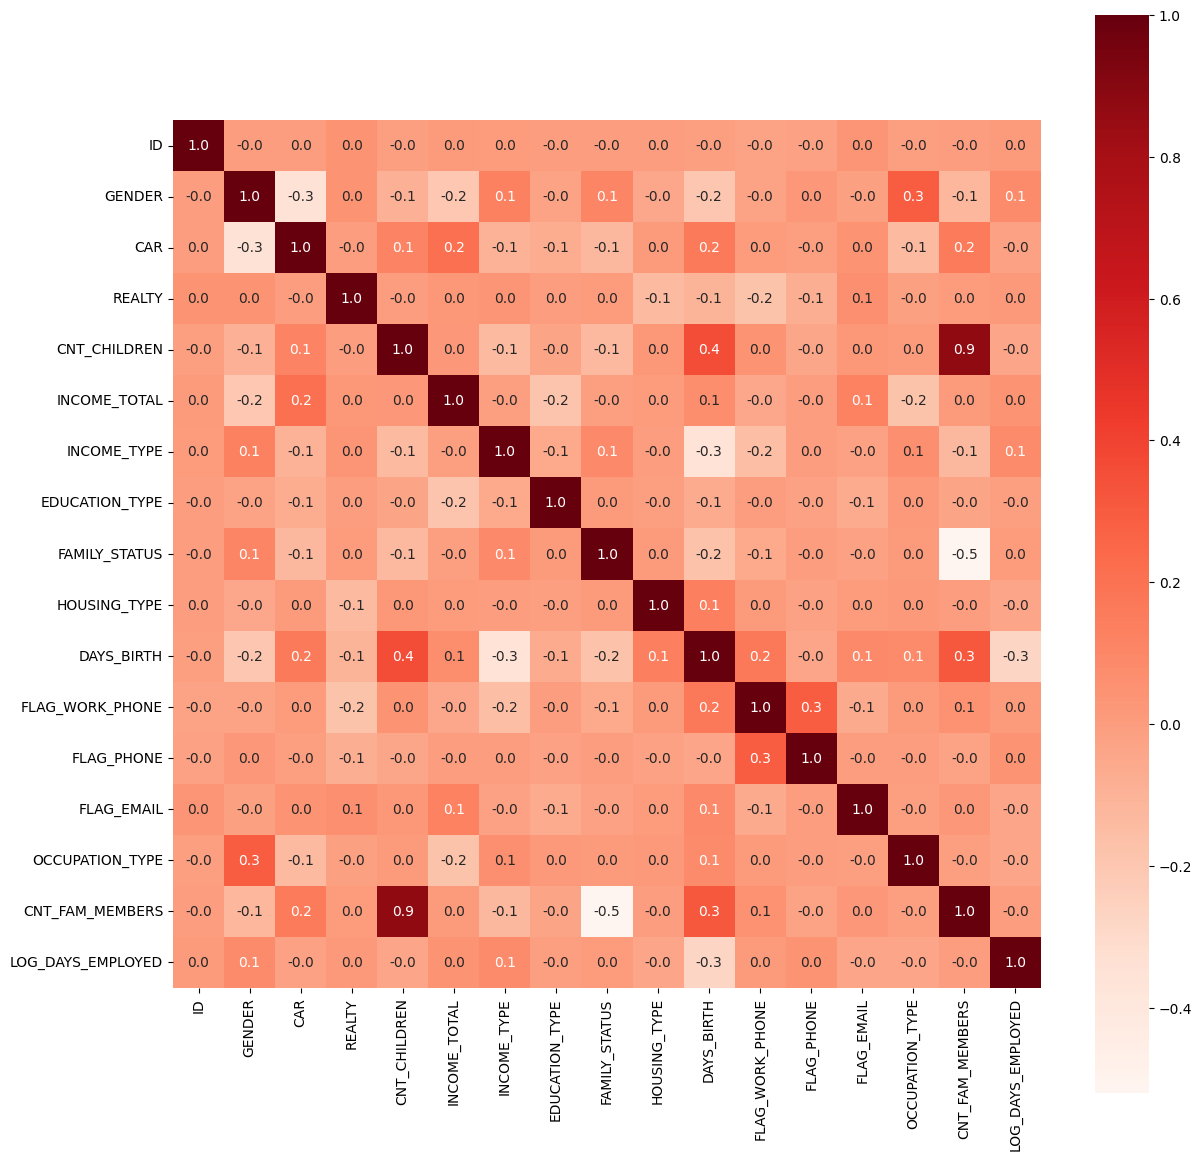

In [52]:
corr = application_cor.corr()
plt.figure(figsize=(14,14))
sb.heatmap(corr, annot=True, cmap='Reds',square=True, fmt=".1f") 
plt.show()

##### Drop `CNT_CHILDREN`

From the heatmap, we could see that `CNT_CHILDREN`, and `CNT_FAM_MEMBERS` are highly correlated, hence we choose to drop `CT_CHILDREN`

In [53]:
application.drop('CNT_CHILDREN', axis=1, inplace=True)

#### Data description of `application` after processing

In [54]:
application.describe(include="all")

,ID,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
count,438557.00,438557.00,438557.00,438557.00,438557.00,438557,438557,438557,438557,438557.00,438557.00,438557.00,438557.00,304354,438557.00,363228.00
unique,NaN,NaN,NaN,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,Laborwk,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,226104,301821,299828,393831,NaN,NaN,NaN,NaN,130049,NaN,NaN
mean,6022176.27,0.67,0.37,0.69,182038.75,NaN,NaN,NaN,NaN,-15997.90,0.21,0.29,0.11,NaN,2.18,7.43
std,571637.02,0.47,0.48,0.46,80856.35,NaN,NaN,NaN,NaN,4185.03,0.40,0.45,0.31,NaN,0.85,1.04
min,5008804.00,0.00,0.00,0.00,26100.00,NaN,NaN,NaN,NaN,-25201.00,0.00,0.00,0.00,NaN,1.00,2.48
25%,5609375.00,0.00,0.00,0.00,121500.00,NaN,NaN,NaN,NaN,-19483.00,0.00,0.00,0.00,NaN,2.00,6.82
50%,6047745.00,1.00,0.00,1.00,160780.50,NaN,NaN,NaN,NaN,-15630.00,0.00,0.00,0.00,NaN,2.00,7.56
75%,6456971.00,1.00,1.00,1.00,225000.00,NaN,NaN,NaN,NaN,-12514.00,0.00,1.00,0.00,NaN,3.00,8.16


In [55]:
application.dtypes

ID                     int64
GENDER                 int64
CAR                    int64
REALTY                 int64
INCOME_TOTAL         float64
INCOME_TYPE           object
EDUCATION_TYPE        object
FAMILY_STATUS         object
HOUSING_TYPE          object
DAYS_BIRTH             int64
FLAG_WORK_PHONE        int64
FLAG_PHONE             int64
FLAG_EMAIL             int64
OCCUPATION_TYPE       object
CNT_FAM_MEMBERS      float64
LOG_DAYS_EMPLOYED    float64
dtype: object

## Data processing for `credit_raw`

### Vintage Analysis

It is used to determine the number of months' data we should consider for performance window. If customer defaults (30 days or more past due) during the performance window, borrower would be considered as a 'bad' customer and labeled as 'event' in dependent variable.

Step 1: Identify the Origination Month
For each ID, the origination month is determined as the earliest MONTHS_BALANCE entry.

In [56]:
credit_data = credit_raw.copy()

In [57]:
credit_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [58]:
origination_month = credit_data.groupby('ID')['MONTHS_BALANCE'].min().reset_index()
origination_month.columns = ['ID', 'Origination_Month']
origination_month.head()

,ID,Origination_Month
0,5001711,-3
1,5001712,-18
2,5001713,-21
3,5001714,-14
4,5001715,-59


Step 2: Merge Origination Month, Calculate Age, and Adjust Quarters
We merge the origination month back to the main dataset, calculate the age of each record in terms of months since origination, and adjust the origination month into quarters with the earliest month treated as Q1.

In [59]:
merged_data = pd.merge(credit_data, origination_month, on='ID', how='left')
merged_data['Age'] = merged_data['MONTHS_BALANCE'] - merged_data['Origination_Month']
earliest_origination = merged_data['Origination_Month'].min()
merged_data['Origination_Quarter'] = ((merged_data['Origination_Month'] - earliest_origination) // 3) + 1
merged_data.head()

,ID,MONTHS_BALANCE,STATUS,Origination_Month,Age,Origination_Quarter
0,5001711,0,X,-3,3,20
1,5001711,-1,0,-3,2,20
2,5001711,-2,0,-3,1,20
3,5001711,-3,0,-3,0,20
4,5001712,0,C,-18,18,15


Step 3: Group Data and Calculate Percentages
The data is grouped by the adjusted origination quarter and age to get the distribution of each STATUS. We then convert the counts to percentages for further analysis.

In [60]:
vintage_data = merged_data.groupby(['Origination_Quarter', 'Age', 'STATUS']).size().unstack().fillna(0)
vintage_data_percentage = vintage_data.div(vintage_data.sum(axis=1), axis=0) * 100

In [61]:
vintage_data.head(10)

STATUS                       0     1    2    3    4    5      C      X
Origination_Quarter Age                                               
1                   0   733.00  1.00 0.00 0.00 0.00 0.00   1.00 526.00
                    1   919.00 12.00 0.00 0.00 0.00 0.00  20.00 308.00
                    2   918.00 18.00 0.00 0.00 0.00 0.00  37.00 276.00
                    3   855.00 18.00 2.00 0.00 0.00 0.00  91.00 272.00
                    4   803.00 23.00 0.00 2.00 0.00 0.00 134.00 260.00
                    5   757.00 21.00 1.00 1.00 1.00 0.00 174.00 260.00
                    6   646.00 28.00 2.00 1.00 0.00 1.00 264.00 262.00
                    7   623.00 22.00 5.00 2.00 0.00 1.00 294.00 245.00
                    8   586.00 21.00 1.00 0.00 1.00 1.00 329.00 240.00
                    9   558.00 23.00 4.00 1.00 0.00 2.00 351.00 221.00

In [62]:
vintage_data_percentage.head(10)

STATUS                      0    1    2    3    4    5     C     X
Origination_Quarter Age                                           
1                   0   58.13 0.08 0.00 0.00 0.00 0.00  0.08 41.71
                    1   72.99 0.95 0.00 0.00 0.00 0.00  1.59 24.46
                    2   73.50 1.44 0.00 0.00 0.00 0.00  2.96 22.10
                    3   69.06 1.45 0.16 0.00 0.00 0.00  7.35 21.97
                    4   65.71 1.88 0.00 0.16 0.00 0.00 10.97 21.28
                    5   62.30 1.73 0.08 0.08 0.08 0.00 14.32 21.40
                    6   53.65 2.33 0.17 0.08 0.00 0.08 21.93 21.76
                    7   52.27 1.85 0.42 0.17 0.00 0.08 24.66 20.55
                    8   49.70 1.78 0.08 0.00 0.08 0.08 27.91 20.36
                    9   48.10 1.98 0.34 0.09 0.00 0.17 30.26 19.05

Step 4: Treat those more than 30 day past due as bad records. Calculate the bad percentage for each age of each quarter cohort.

In [63]:
bad_percentage = vintage_data_percentage[['1', '2', '3', '4', '5']].sum(axis=1).reset_index()
bad_percentage.columns = ['Origination_Quarter', 'Age', 'Bad_Percentage']

bad_percentage.head(10)

,Origination_Quarter,Age,Bad_Percentage
0,1,0,0.08
1,1,1,0.95
2,1,2,1.44
3,1,3,1.62
4,1,4,2.05
5,1,5,1.98
6,1,6,2.66
7,1,7,2.52
8,1,8,2.04
9,1,9,2.59


Step 5: Plot the Results.
We plot the bad rate of these adjusted quarterly cohorts over time, 

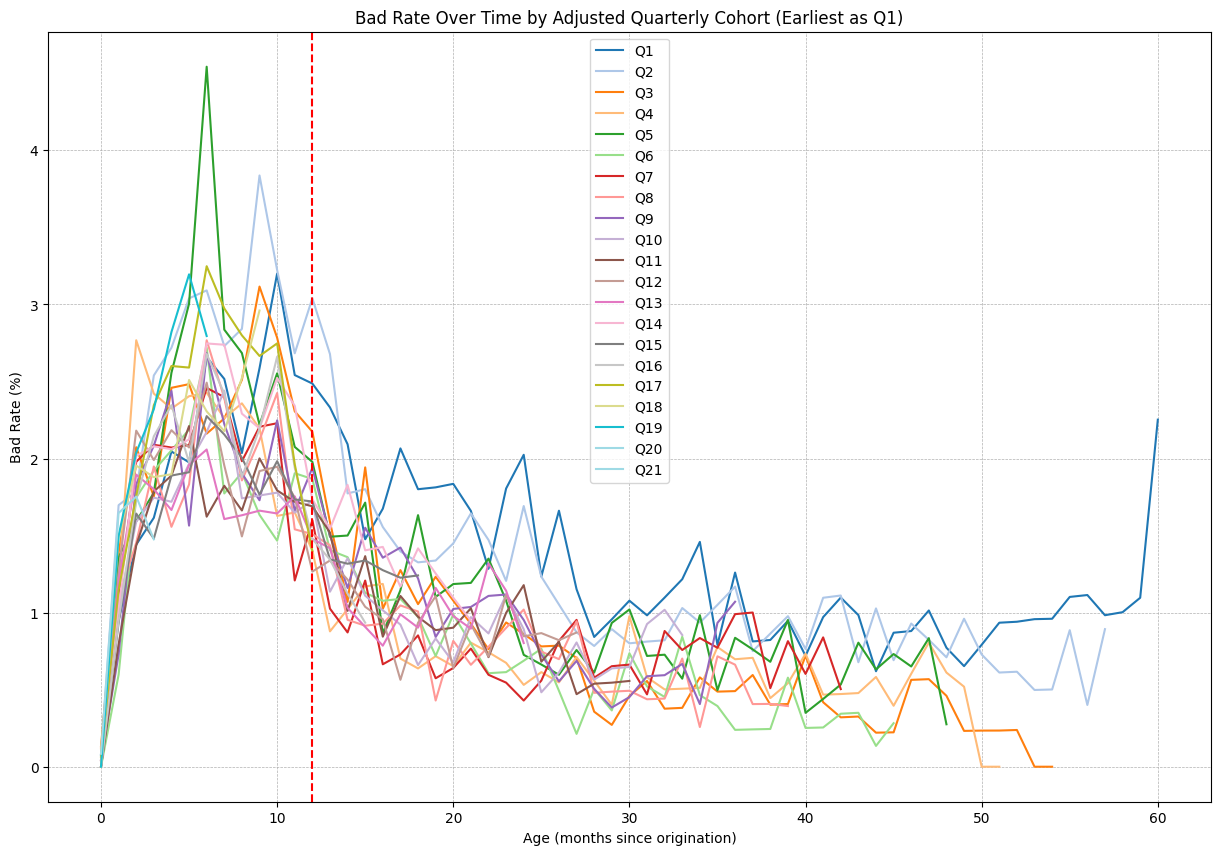

In [64]:
plt.figure(figsize=(15, 10))
color_palette = plt.get_cmap('tab20')
for idx, (cohort, data) in enumerate(bad_percentage.groupby('Origination_Quarter')):
    plt.plot(data['Age'], data['Bad_Percentage'], label=f'Q{cohort}', color=color_palette(idx))
plt.title('Bad Rate Over Time by Adjusted Quarterly Cohort (Earliest as Q1)')
plt.xlabel('Age (months since origination)')
plt.ylabel('Bad Rate (%)')
plt.axvline(x=12, color='red', linestyle='--')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Step 6: Decide on the performance Window according to the graph

In [65]:
performance_window = 12

Step 7: Drop the IDs which have no enough months of data, and label our customer using the performance window.
- If an ID doesn't have enough months of data (i.e., their max age is less than the performance window), then labeling them could be biased. 
- For instance, if we use a 12-month performance window and an ID has only 6 months of data without any "bad" statuses, it might be premature to label them as "Good". They haven't yet had the chance to exhibit behavior over the full 12 months.
- Dropping or excluding these IDs from the labeling process would be more conservative and prudent. By doing so, we ensure that every ID labeled has been evaluated over the complete performance window, making the labels more robust.
- Then for the remaining ID, label them by
    - For each ID, consider their credit records within the performance window after origination.
    - If they have any "bad" statuses (STATUS of 1-5) within this window, label them as "Bad".
    - If they have only "good" statuses within this window, label them as "Good".

In [66]:
labels = []
for customer_id, data in merged_data.groupby('ID'):
    max_age = data['Age'].max()

    # Check if ID has a full performance window of data
    if max_age >= performance_window:
    # Filter records within the performance window
        window_data = data[data['Age'] <= performance_window]
        
        # Check for any bad statuses within the window
        if any(window_data['STATUS'].isin(['1', '2', '3', '4', '5'])):
            labels.append({'ID': customer_id, 'Credit_Label': 'Bad', 'Account_Age': max_age})
        else:
            labels.append({'ID': customer_id, 'Credit_Label': 'Good', 'Account_Age': max_age})

In [67]:
# Convert the list of labels to a DataFrame
credit_labels_window = pd.DataFrame(labels)
credit_labels_window.head()

,ID,Credit_Label,Account_Age
0,5001712,Good,18
1,5001713,Good,21
2,5001714,Good,14
3,5001715,Good,59
4,5001717,Good,21


Plot bar graph to check the distribution.

Text(0.5, 1.0, 'Bar Graph of Label Column')

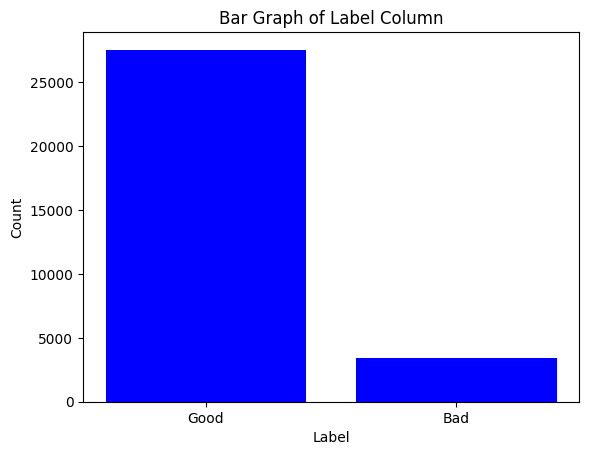

In [68]:
counts_label = credit_labels_window['Credit_Label'].value_counts().reset_index()
counts_label.columns = ['Label', 'Count']

plt.bar(counts_label['Label'], counts_label['Count'], color='blue')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Graph of Label Column')

In [69]:
counts_label.head()

,Label,Count
0,Good,27536
1,Bad,3382


In [70]:
merged = pd.merge(credit_labels_window, application, on='ID', how='inner')

In [71]:
merged['Credit_Label'] = merged['Credit_Label'].replace({'Good': 0, 'Bad': 1})

In [72]:
merged.head()

,ID,Credit_Label,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
0,5008804,1,15,0,1,1,380250.00,Working,Higher education,Civil marriage,Rented apartment,-12005,1,0,0,NaN,2.00,8.42
1,5008805,1,14,0,1,1,380250.00,Working,Higher education,Civil marriage,Rented apartment,-12005,1,0,0,NaN,2.00,8.42
2,5008806,0,29,0,1,1,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,0,0,0,Laborwk,2.00,7.03
3,5008810,0,26,1,0,1,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,0,1,1,officewk,1.00,8.02
4,5008811,0,38,1,0,1,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,0,1,1,officewk,1.00,8.02


In [73]:
merged.describe(include="all")

,ID,Credit_Label,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
count,23419.00,23419.00,23419.00,23419.00,23419.00,23419.00,23419.00,23419,23419,23419,23419,23419.00,23419.00,23419.00,23419.00,16258,23419.00,19650.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,Laborwk,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12054,15711,16440,20918,NaN,NaN,NaN,NaN,6695,NaN,NaN
mean,5078905.29,0.12,28.35,0.66,0.39,0.66,183940.16,NaN,NaN,NaN,NaN,-16060.01,0.23,0.30,0.09,NaN,2.19,7.51
std,42025.60,0.32,12.67,0.47,0.49,0.48,82378.41,NaN,NaN,NaN,NaN,4111.87,0.42,0.46,0.29,NaN,0.85,1.00
min,5008804.00,0.00,12.00,0.00,0.00,0.00,27000.00,NaN,NaN,NaN,NaN,-25152.00,0.00,0.00,0.00,NaN,1.00,3.76
25%,5044507.50,0.00,17.00,0.00,0.00,0.00,121500.00,NaN,NaN,NaN,NaN,-19422.00,0.00,0.00,0.00,NaN,2.00,6.96
50%,5078799.00,0.00,26.00,1.00,0.00,1.00,165600.00,NaN,NaN,NaN,NaN,-15621.00,0.00,0.00,0.00,NaN,2.00,7.67
75%,5115712.00,0.00,37.00,1.00,1.00,1.00,225000.00,NaN,NaN,NaN,NaN,-12642.00,0.00,1.00,0.00,NaN,3.00,8.20


In [74]:
merged["Credit_Label"].value_counts()

Credit_Label
0    20697
1     2722
Name: count, dtype: int64

In [75]:
20697/2722

7.603600293901543

# Section Four: Train-test split

In [76]:
X = merged.iloc[:, 2:]
y = merged["Credit_Label"]

In [77]:
X.head()

,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
0,15,0,1,1,380250.00,Working,Higher education,Civil marriage,Rented apartment,-12005,1,0,0,NaN,2.00,8.42
1,14,0,1,1,380250.00,Working,Higher education,Civil marriage,Rented apartment,-12005,1,0,0,NaN,2.00,8.42
2,29,0,1,1,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,0,0,0,Laborwk,2.00,7.03
3,26,1,0,1,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,0,1,1,officewk,1.00,8.02
4,38,1,0,1,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,0,1,1,officewk,1.00,8.02


In [78]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: Credit_Label, dtype: int64

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3244)

In [80]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (16393, 16)
X_test shape:  (7026, 16)


# Section Five: Data Processing After Train-test Split

## Scaling

In [81]:
X_train.columns

Index(['Account_Age', 'GENDER', 'CAR', 'REALTY', 'INCOME_TOTAL', 'INCOME_TYPE', 'EDUCATION_TYPE', 'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_BIRTH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'LOG_DAYS_EMPLOYED'], dtype='object')

In [82]:
scaler = MinMaxScaler()

columns_to_scale = ['Account_Age',  
                    'INCOME_TOTAL', 
                    'DAYS_BIRTH', 
                    'LOG_DAYS_EMPLOYED', 
                    'CNT_FAM_MEMBERS']

# Fit the scaler on the training data
scaler.fit(X_train[columns_to_scale])

# Transform the specified columns in both training and test DataFrames
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


In [83]:
X_train.head()

,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
21899,0.12,1,0,1,0.35,Working,Higher education,Single / not married,House / apartment,0.83,0,1,0,officewk,0.00,0.47
21244,0.15,1,1,1,0.69,State servant,Higher education,Married,House / apartment,0.50,0,0,0,hightecwk,0.33,0.89
4170,0.40,1,1,1,0.69,Commercial associate,Higher education,Married,House / apartment,0.30,0,0,0,officewk,0.33,0.83
6034,0.83,0,1,1,0.49,Pensioner,Secondary / secondary special,Married,House / apartment,0.16,0,0,0,NaN,0.33,NaN
13781,0.19,1,1,1,0.30,Working,Higher education,Married,House / apartment,0.74,0,0,0,hightecwk,0.33,0.77


In [84]:
X_test.head()

,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
10940,0.60,0,1,1,1.00,Working,Higher education,Married,House / apartment,0.58,0,0,0,hightecwk,0.67,0.36
3488,0.08,1,1,1,0.75,Commercial associate,Higher education,Widow,House / apartment,0.35,0,1,1,NaN,0.00,0.83
14362,0.17,0,0,1,0.43,Working,Secondary / secondary special,Married,House / apartment,0.88,1,1,0,Laborwk,0.33,0.57
20058,0.21,0,1,1,0.30,Working,Secondary / secondary special,Civil marriage,Rented apartment,0.81,0,0,0,Laborwk,0.33,0.51
15875,0.33,0,1,1,0.69,Working,Higher education,Married,House / apartment,0.62,0,0,0,NaN,0.67,0.42


## Upsampling/SMOTENC

### Class distribution before upsampling/SMOTENC

In [85]:
y_train.value_counts()

Credit_Label
0    14467
1     1926
Name: count, dtype: int64

### Random upsampling

In [86]:
ros = RandomOverSampler(sampling_strategy=1.0, random_state=3244)
X_train_up, y_train_up = ros.fit_resample(X_train, y_train)
X_test_up = X_test.copy()
y_test_up = y_test.copy()

In [87]:
X_train_up.head()

,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
0,0.12,1,0,1,0.35,Working,Higher education,Single / not married,House / apartment,0.83,0,1,0,officewk,0.00,0.47
1,0.15,1,1,1,0.69,State servant,Higher education,Married,House / apartment,0.50,0,0,0,hightecwk,0.33,0.89
2,0.40,1,1,1,0.69,Commercial associate,Higher education,Married,House / apartment,0.30,0,0,0,officewk,0.33,0.83
3,0.83,0,1,1,0.49,Pensioner,Secondary / secondary special,Married,House / apartment,0.16,0,0,0,NaN,0.33,NaN
4,0.19,1,1,1,0.30,Working,Higher education,Married,House / apartment,0.74,0,0,0,hightecwk,0.33,0.77


In [88]:
y_train_up.value_counts()

Credit_Label
1    14467
0    14467
Name: count, dtype: int64

### SMOTENC

#### Dealing withe missing values

SMOTENC does not handle missing values. Therefore, before applying SMOTENC, we first need to deal with the missing values.
- `OCCUPATION_TYPE` is categorical data, thus we decided to replace the NaN values with "Unknown" categoty.
- `DAYS_EMPLOYED` is numerical data, thus we decided to replace the NaN values with mean value of the column.
- We ensure that any imputation strategy we apply to our test data are consistent with what we did for the training data to ensure cosistency while preventing data leakage.

In [89]:
X_train_smotenc = X_train.copy()
y_train_smotenc = y_train.copy()
X_test_smotenc = X_test.copy()
y_test_smotenc = y_test.copy()

# Deal with missing values in OCCUPATION_TYPE
X_train_smotenc['OCCUPATION_TYPE'] = X_train_smotenc['OCCUPATION_TYPE'].fillna('Unknown')
X_test_smotenc['OCCUPATION_TYPE'] = X_test_smotenc['OCCUPATION_TYPE'].fillna('Unknown')

# Replace missing values in DAYS_EMPLOYED with mean value of the column
mean_value = X_train_smotenc['LOG_DAYS_EMPLOYED'].mean()
X_train_smotenc['LOG_DAYS_EMPLOYED'].fillna(mean_value, inplace=True)
X_test_smotenc['LOG_DAYS_EMPLOYED'].fillna(mean_value, inplace=True)

In [90]:
smote = SMOTENC(categorical_features= ["INCOME_TYPE","EDUCATION_TYPE",'FAMILY_STATUS','HOUSING_TYPE','OCCUPATION_TYPE'],
                random_state=42)
X_train_smotenc, y_train_smotenc = smote.fit_resample(X_train_smotenc, y_train_smotenc)

In [91]:
X_train_smotenc.head()

,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED
0,0.12,1,0,1,0.35,Working,Higher education,Single / not married,House / apartment,0.83,0,1,0,officewk,0.00,0.47
1,0.15,1,1,1,0.69,State servant,Higher education,Married,House / apartment,0.50,0,0,0,hightecwk,0.33,0.89
2,0.40,1,1,1,0.69,Commercial associate,Higher education,Married,House / apartment,0.30,0,0,0,officewk,0.33,0.83
3,0.83,0,1,1,0.49,Pensioner,Secondary / secondary special,Married,House / apartment,0.16,0,0,0,Unknown,0.33,0.64
4,0.19,1,1,1,0.30,Working,Higher education,Married,House / apartment,0.74,0,0,0,hightecwk,0.33,0.77


In [92]:
y_train_smotenc.value_counts()

Credit_Label
1    14467
0    14467
Name: count, dtype: int64

In [93]:
print(X_train_smotenc.shape)
print(X_test_smotenc.shape)

(28934, 16)
(7026, 16)


## Summary

- `X_train` and `X_test` are first processed with `MinMaxScaler` to narmalize all numerical columns, including 'Account_Age', 'CNT_CHILDREN', 'INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS'
- `X_train_up`, `y_train_up` are produced by random oversampling using `RandomOverSampler`, without handling missing values.
- `X_train_smotenc`, `y_train_smotenc` are produced by SMOTE-NC, which is an extension of SMOTE capable of handling numerical and categorical data. Before apply SMOTE-NC, bothe the training and test set are pre-processed to handle missing values.

# Section Six: Model Implementation

## XGBoost

### Transforming categorical variables into numerical columns using one hot encoding

In [94]:
def ohencode(X_train, X_test):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    cat_columns = ["INCOME_TYPE","EDUCATION_TYPE",'FAMILY_STATUS','HOUSING_TYPE','OCCUPATION_TYPE']
    
    for cat_col in cat_columns:
        X_train[cat_col] = X_train[cat_col].astype('category')
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    feature_arr_train = ohe.fit_transform(X_train[cat_columns]).toarray()
    feature_labels = ohe.get_feature_names_out(cat_columns)
    
    # Create dataframe with original indices
    features_train = pd.DataFrame(feature_arr_train, columns=feature_labels, index=X_train.index)
    X_train = X_train.drop(columns=cat_columns)
    X_train = pd.concat([X_train, features_train], axis=1)
    
    feature_arr_test = ohe.transform(X_test[cat_columns]).toarray()
    
    # Create dataframe with original indices
    features_test = pd.DataFrame(feature_arr_test, columns=feature_labels, index=X_test.index)
    X_test = X_test.drop(columns=cat_columns)
    X_test = pd.concat([X_test, features_test], axis=1)
    
    return X_train, X_test

X_train_ohe, X_test_ohe = ohencode(X_train, X_test)
X_train_up_ohe, X_test_up_ohe = ohencode(X_train_up, X_test_up)
X_train_smotenc_ohe, X_test_smotenc_ohe = ohencode(X_train_smotenc, X_test_smotenc)
X_train_up_ohe.head(10)


,Account_Age,GENDER,CAR,REALTY,INCOME_TOTAL,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,LOG_DAYS_EMPLOYED,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Student,INCOME_TYPE_Working,EDUCATION_TYPE_Academic degree,EDUCATION_TYPE_Higher education,EDUCATION_TYPE_Incomplete higher,EDUCATION_TYPE_Lower secondary,EDUCATION_TYPE_Secondary / secondary special,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,HOUSING_TYPE_Co-op apartment,HOUSING_TYPE_House / apartment,HOUSING_TYPE_Municipal apartment,HOUSING_TYPE_Office apartment,HOUSING_TYPE_Rented apartment,HOUSING_TYPE_With parents,OCCUPATION_TYPE_Laborwk,OCCUPATION_TYPE_hightecwk,OCCUPATION_TYPE_officewk,OCCUPATION_TYPE_nan
0,0.12,1,0,1,0.35,0.83,0,1,0,0.00,0.47,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0.15,1,1,1,0.69,0.50,0,0,0,0.33,0.89,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,0.40,1,1,1,0.69,0.30,0,0,0,0.33,0.83,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0.83,0,1,1,0.49,0.16,0,0,0,0.33,NaN,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,0.19,1,1,1,0.30,0.74,0,0,0,0.33,0.77,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
5,0.10,1,0,0,0.81,0.38,1,1,0,0.33,0.83,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
6,0.21,1,0,1,0.34,0.34,0,0,0,0.33,NaN,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
7,0.38,1,1,1,0.69,0.30,0,0,0,0.33,0.83,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
8,0.23,1,0,1,0.43,0.61,1,1,0,0.00,0.79,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
9,0.12,1,0,1,0.88,0.62,0,0,0,0.33,0.39,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


### XGBoost with original data

In [95]:
# Test data predictions
xgb_ori = xgb.XGBClassifier(enable_categorical = True, device="cuda")
xgb_ori.fit(X_train_ohe,y_train)
y_pred = xgb_ori.predict(X_test_ohe)

# Training data predictions
y_train_pred = xgb_ori.predict(X_train_ohe)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_fbeta = fbeta_score(y_train, y_train_pred, beta=2)
train_f1 = f1_score(y_train, y_train_pred)
train_auc_roc = roc_auc_score(y_train,y_train_pred)

print("Training Accuracy: {:.2f} %".format(train_accuracy * 100))
print("Training Precision: {:.2f} %".format(train_precision * 100))
print("Training Recall: {:.2f} %".format(train_recall * 100))
print("Training F2 Score: {:.2f} %".format(train_fbeta * 100))
print("Training F1 Score: {:.2f} %".format(train_f1 * 100))
print("Training ROC AUC Score: {:.2f} %".format(train_auc_roc * 100))


print("Accuracy    using XGBoost on Original Data   : {:.2f} %".format(np.round(accuracy_score(y_test, y_pred),4)*100))
print("Precision   using XGBoost on Original Data   : {:.2f} %".format(np.round(precision_score(y_test, y_pred),4)*100))
print("Recall      using XGBoost on Original Data   : {:.2f} %".format(np.round(recall_score(y_test, y_pred),4)*100))
print("F2 Score    using XGBoost on Original Data   : {:.2f} %".format(np.round(fbeta_score(y_test, y_pred,beta =2 ),4)*100))
print("F1 Score    using XGBoost on Original Data   : {:.2f} %".format(np.round(f1_score(y_test, y_pred),4)*100))
print("ROC AUC Score   using XGBoost on Original Data   : {:.2f} %".format(np.round(roc_auc_score(y_test, y_pred),4)*100))

Training Accuracy: 92.16 %
Training Precision: 95.20 %
Training Recall: 35.05 %
Training F2 Score: 40.12 %
Training F1 Score: 51.23 %
Training ROC AUC Score: 67.41 %
Accuracy    using XGBoost on Original Data   : 88.97 %
Precision   using XGBoost on Original Data   : 56.52 %
Recall      using XGBoost on Original Data   : 11.43 %
F2 Score    using XGBoost on Original Data   : 13.60 %
F1 Score    using XGBoost on Original Data   : 19.02 %
ROC AUC Score   using XGBoost on Original Data   : 55.15 %


### XGBoost with upsampled data before hyper-tuning parameters

In [96]:
# Test data predictions
xgb_up = xgb.XGBClassifier(enable_categorical = True, device="cuda")
xgb_up.fit(X_train_up_ohe,y_train_up)
y_pred_up = xgb_up.predict(X_test_up_ohe)

# Training data predictions
y_train_pred_up = xgb_up.predict(X_train_up_ohe)
train_precision = precision_score(y_train_up, y_train_pred_up)
train_recall = recall_score(y_train_up, y_train_pred_up)
train_accuracy = accuracy_score(y_train_up, y_train_pred_up)
train_fbeta = fbeta_score(y_train_up, y_train_pred_up, beta=2)
train_f1 = f1_score(y_train_up, y_train_pred_up)
train_auc_roc = roc_auc_score(y_train_up,y_train_pred_up)

print("Training Accuracy: {:.2f} %".format(train_accuracy * 100))
print("Training Precision: {:.2f} %".format(train_precision * 100))
print("Training Recall: {:.2f} %".format(train_recall * 100))
print("Training F2 Score: {:.2f} %".format(train_fbeta * 100))
print("Training F1 Score: {:.2f} %".format(train_f1 * 100))
print("Training ROC AUC Score: {:.2f} %".format(train_auc_roc * 100))

print("Accuracy    using XGBoost on Upsampled Data   : {:.2f} %".format(np.round(accuracy_score(y_test_up, y_pred_up),4)*100))
print("Precision   using XGBoost on Upsampled Data   : {:.2f} %".format(np.round(precision_score(y_test_up, y_pred_up),4)*100))
print("Recall      using XGBoost on Upsampled Data   : {:.2f} %".format(np.round(recall_score(y_test_up, y_pred_up),4)*100))
print("F2 Score    using XGBoost on Upsampled Data   : {:.2f} %".format(np.round(fbeta_score(y_test_up, y_pred_up,beta =2 ),4)*100))
print("F1 Score    using XGBoost on Upsampled Data   : {:.2f} %".format(np.round(f1_score(y_test_up, y_pred_up),4)*100))
print("ROC AUC Score   using XGBoost on Upsampled Data   : {:.2f} %".format(np.round(roc_auc_score(y_test_up, y_pred_up),4)*100))

Training Accuracy: 91.91 %
Training Precision: 90.08 %
Training Recall: 94.19 %
Training F2 Score: 93.34 %
Training F1 Score: 92.09 %
Training ROC AUC Score: 91.91 %
Accuracy    using XGBoost on Upsampled Data   : 81.23 %
Precision   using XGBoost on Upsampled Data   : 29.10 %
Recall      using XGBoost on Upsampled Data   : 45.73 %
F2 Score    using XGBoost on Upsampled Data   : 41.04 %
F1 Score    using XGBoost on Upsampled Data   : 35.56 %
ROC AUC Score   using XGBoost on Upsampled Data   : 65.75 %


### XGBoost with SMOTENC data before hyper-tuning parameters

In [97]:
# Test data predictions
xgb_smotenc = xgb.XGBClassifier()
xgb_smotenc.fit(X_train_smotenc_ohe,y_train_smotenc)
y_pred_smotenc = xgb_smotenc.predict(X_test_smotenc_ohe)

# Training data predictions
y_train_pred_smotenc = xgb_smotenc.predict(X_train_smotenc_ohe)
train_precision = precision_score(y_train_smotenc, y_train_pred_smotenc)
train_recall = recall_score(y_train_smotenc, y_train_pred_smotenc)
train_accuracy = accuracy_score(y_train_smotenc, y_train_pred_smotenc)
train_fbeta = fbeta_score(y_train_smotenc, y_train_pred_smotenc, beta=2)
train_f1 = f1_score(y_train_smotenc, y_train_pred_smotenc)
train_auc_roc = roc_auc_score(y_train_smotenc,y_train_pred_smotenc)

print("Training Accuracy: {:.2f} %".format(train_accuracy * 100))
print("Training Recall: {:.2f} %".format(train_recall * 100))
print("Training Precision: {:.2f} %".format(train_precision * 100))
print("Training F2 Score: {:.2f} %".format(train_fbeta * 100))
print("Training F1 Score: {:.2f} %".format(train_f1 * 100))
print("Training ROC AUC Score: {:.2f} %".format(train_auc_roc * 100))

print("Accuracy    using XGBoost on SMOTENC Data   : {:.2f} %".format(np.round(accuracy_score(y_test_smotenc, y_pred_smotenc),4)*100))
print("Precision   using XGBoost on SMOTENC Data   : {:.2f} %".format(np.round(precision_score(y_test_smotenc, y_pred_smotenc),4)*100))
print("Recall      using XGBoost on SMOTENC Data   : {:.2f} %".format(np.round(recall_score(y_test_smotenc, y_pred_smotenc),4)*100))
print("F2 Score    using XGBoost on SMOTENC Data   : {:.2f} %".format(np.round(fbeta_score(y_test_smotenc, y_pred_smotenc,beta=2),4)*100))
print("F1 Score    using XGBoost on SMOTENC Data   : {:.2f} %".format(np.round(f1_score(y_test_smotenc, y_pred_smotenc),4)*100))
print("ROC AUC Score   using XGBoost on SMOTENC Data   : {:.2f} %".format(np.round(roc_auc_score(y_test_smotenc, y_pred_smotenc),4)*100))

Training Accuracy: 93.85 %
Training Recall: 90.05 %
Training Precision: 97.47 %
Training F2 Score: 91.44 %
Training F1 Score: 93.61 %
Training ROC AUC Score: 93.85 %
Accuracy    using XGBoost on SMOTENC Data   : 86.59 %
Precision   using XGBoost on SMOTENC Data   : 35.22 %
Recall      using XGBoost on SMOTENC Data   : 21.86 %
F2 Score    using XGBoost on SMOTENC Data   : 23.65 %
F1 Score    using XGBoost on SMOTENC Data   : 26.98 %
ROC AUC Score   using XGBoost on SMOTENC Data   : 58.36 %


# Section Seven: Model Tuning & Feature Importance

### XGBoost with Hyperparameter tuning using Optuna

#### Original Data

#### Defining the objective function

In [98]:
xgb_ori_op = xgb
def XGBclassifier_optuna_ori(trial,X_train=X_train_ohe,X_test=X_test_ohe,y_train=y_train,y_test=y_test):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    classifier= xgb_ori_op.XGBClassifier(**params)  
    classifier.fit(X_train_ohe, y_train)  
    y_pred = classifier.predict(X_test_ohe)
    acc = accuracy_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, beta = 2)
    
    #defining custom scoring 
    f2_weight = 0.6
    accuracy_weight = 0.4
    composite_score = f2_weight * fbeta + accuracy_weight * acc
    
    return composite_score

#### Searching for best parameters

In [99]:
study_ori = optuna.create_study(direction="maximize")
study_ori.optimize(XGBclassifier_optuna_ori, n_trials=300)

print("Number of finished trials: ", len(study_ori.trials))
print("Best trial:")
trial = study_ori.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
params = []
for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2023-12-01 22:28:27,494] A new study created in memory with name: no-name-08179369-720c-458f-bb4f-b4164636c1f8
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/1900735015.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/1900735015.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/1900735015.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v

Number of finished trials:  300
Best trial:
  Value: 0.5575603360421373
  Params: 
    max_depth: 9
    learning_rate: 0.9214910162192985
    n_estimators: 341
    min_child_weight: 3
    gamma: 7.207104547529593e-05
    subsample: 0.7685059479403973
    colsample_bytree: 0.3109253670709359
    reg_alpha: 0.0011384151530943853
    reg_lambda: 0.04807795935524754


#### Xgboost on original data with optuna

In [112]:
# test data predictions
xgb_ori_2 = xgb
xgb_ori3 = xgb_ori_2.XGBClassifier(max_depth = 9, learning_rate = 0.9214910162192985,
    n_estimators = 341,
    min_child_weight = 3,
    gamma = 7.207104547529593e-05,
    subsample = 0.7685059479403973,
    colsample_bytree = 0.3109253670709359,
    reg_alpha= 0.0011384151530943853,
    reg_lambda = 0.04807795935524754)

#training data predictions
xgb_ori3.fit(X_train_ohe, y_train)
y_train_pred_ori_op = xgb_ori3.predict(X_train_ohe)

train_precision = precision_score(y_train, y_train_pred_ori_op)
train_recall = recall_score(y_train, y_train_pred_ori_op)
train_accuracy = accuracy_score(y_train, y_train_pred_ori_op)
train_fbeta = fbeta_score(y_train, y_train_pred_ori_op, beta=2)
train_f1 = f1_score(y_train, y_train_pred_ori_op)
train_auc_roc = roc_auc_score(y_train,y_train_pred_ori_op)

print("Training Precision: {:.2f} %".format(train_precision * 100))
print("Training Accuracy: {:.2f} %".format(train_accuracy * 100))
print("Training Recall: {:.2f} %".format(train_recall * 100))
print("Training F2 Score: {:.2f} %".format(train_fbeta * 100))
print("Training F1 Score: {:.2f} %".format(train_f1 * 100))
print("Training ROC AUC Score: {:.2f} %".format(train_auc_roc * 100))


#testing
xgb_ori3.fit(X_train_ohe, y_train)
y_pred_ori_op = xgb_ori3.predict(X_test_ohe)

print("Accuracy    using XGBoost and Optuna on Original Data   : {:.2f} %".format(np.round(accuracy_score(y_test, y_pred_ori_op),4)*100))
print("Precision   using XGBoost and Optuna on Original Data   : {:.2f} %".format(np.round(precision_score(y_test, y_pred_ori_op),4)*100))
print("Recall      using XGBoost and Optuna on Original Data   : {:.2f} %".format(np.round(recall_score(y_test, y_pred_ori_op),4)*100))
print("F2 Score    using XGBoost on Optuna on Original Data   : {:.2f} %".format(np.round(fbeta_score(y_test, y_pred_ori_op,beta=2),4)*100))
print("F1 Score    using XGBoost on Optuna on Original Data   : {:.2f} %".format(np.round(f1_score(y_test, y_pred_ori_op),4)*100))
print("ROC AUC Score   using XGBoost on Optuna on Original Data   : {:.2f} %".format(np.round(roc_auc_score(y_test, y_pred_ori_op),4)*100))

Training Precision: 96.77 %
Training Accuracy: 98.83 %
Training Recall: 93.20 %
Training F2 Score: 93.89 %
Training F1 Score: 94.95 %
Training ROC AUC Score: 96.39 %
Accuracy    using XGBoost and Optuna on Original Data   : 87.01 %
Precision   using XGBoost and Optuna on Original Data   : 41.04 %
Recall      using XGBoost and Optuna on Original Data   : 33.67 %
F2 Score    using XGBoost on Optuna on Original Data   : 34.92 %
F1 Score    using XGBoost on Optuna on Original Data   : 36.99 %
ROC AUC Score   using XGBoost on Optuna on Original Data   : 63.74 %


#### Upsampled Data

##### Defining the objective function

In [101]:
xgb_up_op = xgb
def XGBclassifier_optuna_up(trial,X_train=X_train_up_ohe,X_test=X_test_up_ohe,y_train=y_train_up,y_test=y_test_up):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    classifier= xgb_up_op.XGBClassifier(**params)  
    classifier.fit(X_train_up_ohe, y_train_up)  
    y_pred_up = classifier.predict(X_test_up_ohe)
    acc = accuracy_score(y_test_up, y_pred_up)
    fbeta = fbeta_score(y_test_up, y_pred_up, beta = 2)
    
    #defining custom scoring 
    f2_weight = 0.6
    accuracy_weight = 0.4
    composite_score = f2_weight * fbeta + accuracy_weight * acc
    
    return composite_score


#### Searching for best parameters

In [102]:
study = optuna.create_study(direction="maximize")
study.optimize(XGBclassifier_optuna_up, n_trials=300)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
params = []
for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2023-12-01 22:37:33,360] A new study created in memory with name: no-name-83543396-521a-425f-bffd-b0c5ff6619e3
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/2210924659.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/2210924659.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/2210924659.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v

Number of finished trials:  300
Best trial:
  Value: 0.5978863958576688
  Params: 
    max_depth: 9
    learning_rate: 0.10546585767854678
    n_estimators: 464
    min_child_weight: 2
    gamma: 0.5775800041069326
    subsample: 0.4220123506196419
    colsample_bytree: 0.28643906476821895
    reg_alpha: 0.002205920390872864
    reg_lambda: 0.0005730530706454615


#### XGBoost with hypertuned-parameters on upsampled data

In [111]:
xgb_up2 = xgb
xgb_up3 = xgb_up2.XGBClassifier(max_depth = 9, learning_rate = 0.10546585767854678,
    n_estimators = 464,
    min_child_weight = 2,
    gamma = 0.5775800041069326,
    subsample = 0.4220123506196419,
    colsample_bytree = 0.28643906476821895,
    reg_alpha= 0.002205920390872864,
    reg_lambda = 0.0005730530706454615)

#test data predictions
xgb_up3.fit(X_train_up_ohe, y_train_up)
y_pred_up_op = xgb_up3.predict(X_test_up_ohe)

#training data predictions
xgb_up3.fit(X_train_up_ohe, y_train_up)
y_train_pred_up_op = xgb_up3.predict(X_train_up_ohe)

train_precision = precision_score(y_train_up, y_train_pred_up_op)
train_recall = recall_score(y_train_up, y_train_pred_up_op)
train_accuracy = accuracy_score(y_train_up, y_train_pred_up_op)
train_fbeta = fbeta_score(y_train_up, y_train_pred_up_op, beta=2)
train_f1 = f1_score(y_train_up, y_train_pred_up_op)
train_auc_roc = roc_auc_score(y_train_up,y_train_pred_up_op)

print("Training Accuracy: {:.2f} %".format(train_accuracy * 100))
print("Training Recall: {:.2f} %".format(train_recall * 100))
print("Training Precision: {:.2f} %".format(train_precision * 100))
print("Training F2 Score: {:.2f} %".format(train_fbeta * 100))
print("Training F1 Score: {:.2f} %".format(train_f1 * 100))
print("Training ROC AUC Score: {:.2f} %".format(train_auc_roc * 100))

print("Accuracy    using XGBoost and Optuna on Upsampled Data   : {:.2f} %".format(np.round(accuracy_score(y_test_up, y_pred_up_op),4)*100))
print("Precision   using XGBoost and Optuna on Upsampled Data   : {:.2f} %".format(np.round(precision_score(y_test_up, y_pred_up_op),4)*100))
print("Recall      using XGBoost and Optuna on Upsampled Data   : {:.2f} %".format(np.round(recall_score(y_test_up, y_pred_up_op),4)*100))
print("F2 Score    using XGBoost on Optuna on Upsampled Data   : {:.2f} %".format(np.round(fbeta_score(y_test_up, y_pred_up_op,beta=2),4)*100))
print("F1 Score    using XGBoost on Optuna on Upsampled Data   : {:.2f} %".format(np.round(f1_score(y_test_up, y_pred_up_op),4)*100))
print("ROC AUC Score   using XGBoost on Optuna on Upsampled Data   : {:.2f} %".format(np.round(roc_auc_score(y_test_up, y_pred_up_op),4)*100))

Training Accuracy: 96.70 %
Training Recall: 98.87 %
Training Precision: 94.75 %
Training F2 Score: 98.02 %
Training F1 Score: 96.77 %
Training ROC AUC Score: 96.70 %
Accuracy    using XGBoost and Optuna on Upsampled Data   : 85.53 %
Precision   using XGBoost and Optuna on Upsampled Data   : 38.00 %
Recall      using XGBoost and Optuna on Upsampled Data   : 43.97 %
F2 Score    using XGBoost on Optuna on Upsampled Data   : 42.63 %
F1 Score    using XGBoost on Optuna on Upsampled Data   : 40.77 %
ROC AUC Score   using XGBoost on Optuna on Upsampled Data   : 67.40 %


### Feature importance using upsampled data


                                   feature_names  feature_importance
5                                     DAYS_BIRTH                0.05
10                             LOG_DAYS_EMPLOYED                0.04
4                                   INCOME_TOTAL                0.04
0                                    Account_Age                0.04
8                                     FLAG_EMAIL                0.03
33                     OCCUPATION_TYPE_hightecwk                0.03
19                EDUCATION_TYPE_Lower secondary                0.03
28              HOUSING_TYPE_Municipal apartment                0.03
35                           OCCUPATION_TYPE_nan                0.03
23                       FAMILY_STATUS_Separated                0.03
21                  FAMILY_STATUS_Civil marriage                0.03
18              EDUCATION_TYPE_Incomplete higher                0.03
7                                     FLAG_PHONE                0.03
2                                 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


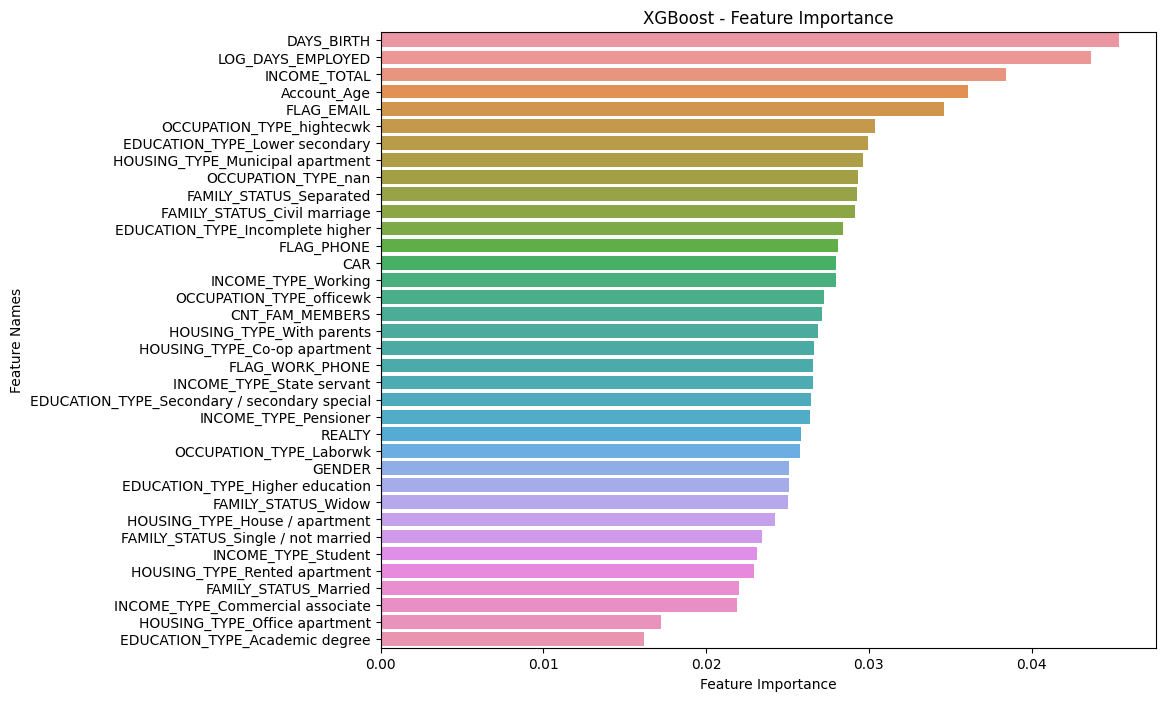

In [104]:
# Get feature importances
feature_importance_up = xgb_up3.feature_importances_

# Visualize feature importances
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    print(fi_df)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(feature_importance_up, X_train_up_ohe.columns, 'XGBoost')
plt.show()



#### SMOTENC Data

#### Defining objective function

In [105]:
xgb_smotenc_op = xgb
def XGBclassifier_optuna_smotenc(trial,X_train=X_train_smotenc_ohe,X_test=X_test_smotenc_ohe,y_train=y_train_smotenc,y_test=y_test_smotenc):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    classifier= xgb_smotenc_op.XGBClassifier(**params)  
    classifier.fit(X_train_smotenc_ohe, y_train_smotenc)  
    y_pred_smotenc = classifier.predict(X_test_smotenc_ohe)
    acc = accuracy_score(y_test_smotenc, y_pred_smotenc)
    fbeta = fbeta_score(y_test_smotenc, y_pred_smotenc, beta = 2)
    
    #defining custom scoring 
    f2_weight = 0.6
    accuracy_weight = 0.4
    composite_score = f2_weight * fbeta + accuracy_weight * acc
    
    return composite_score
    

#### Search for the best parameters

In [106]:
study_smotenc = optuna.create_study(direction="maximize")
study_smotenc.optimize(XGBclassifier_optuna_smotenc, n_trials=300)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study_smotenc.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
params = []
for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2023-12-01 22:48:51,769] A new study created in memory with name: no-name-58010e4c-ec43-4adb-9deb-913d79bf2290
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/515390748.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/515390748.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/515390748.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0

/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/515390748.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/515390748.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_73961/515390748.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsamp

Number of finished trials:  300
Best trial:
  Value: 0.5714719616520629
  Params: 
    max_depth: 9
    learning_rate: 0.5330258894279093
    n_estimators: 483
    min_child_weight: 1
    gamma: 1.5654731664137108e-07
    subsample: 0.850375501427512
    colsample_bytree: 0.301494520829748
    reg_alpha: 5.8982135471454217e-05
    reg_lambda: 0.0056359131423070795


#### XGBoost with hypertuned-parameters on SMOTENC data

In [110]:
xgb_smotenc2 = xgb
xgb_smotenc3 = xgb_smotenc2.XGBClassifier(max_depth= 9, learning_rate = 0.5330258894279093,
    n_estimators = 483,
    min_child_weight = 1,
    gamma = 1.5654731664137108e-07,
    subsample = 0.850375501427512,
    colsample_bytree = 0.301494520829748,
    reg_alpha= 5.8982135471454217e-05,
    reg_lambda = 0.0056359131423070795)

#testing data predictions
xgb_smotenc3.fit(X_train_smotenc_ohe, y_train_smotenc)
y_pred_smotenc_op = xgb_smotenc3.predict(X_test_smotenc_ohe)

#training data predictions
xgb_smotenc3.fit(X_train_smotenc_ohe, y_train_smotenc)
y_train_pred_smotenc_op = xgb_smotenc3.predict(X_train_smotenc_ohe)

train_precision = precision_score(y_train_smotenc, y_train_pred_smotenc_op)
train_recall = recall_score(y_train_smotenc, y_train_pred_smotenc_op)
train_accuracy = accuracy_score(y_train_smotenc, y_train_pred_smotenc_op)
train_fbeta = fbeta_score(y_train_smotenc, y_train_pred_smotenc_op, beta=2)
train_f1 = f1_score(y_train_smotenc, y_train_pred_smotenc_op)
train_auc_roc = roc_auc_score(y_train_smotenc,y_train_pred_smotenc_op)

print("Training Accuracy: {:.2f} %".format(train_accuracy * 100))
print("Training Recall: {:.2f} %".format(train_recall * 100))
print("Training Precision: {:.2f} %".format(train_precision * 100))
print("Training F2 Score: {:.2f} %".format(train_fbeta * 100))
print("Training F1 Score: {:.2f} %".format(train_f1 * 100))
print("Training ROC AUC Score: {:.2f} %".format(train_auc_roc * 100))

print("Accuracy    using XGBoost and Optuna on SMOTENC Data   : {:.2f} %".format(np.round(accuracy_score(y_test_smotenc, y_pred_smotenc_op),4)*100))
print("Precision   using XGBoost and Optuna on SMOTENC Data   : {:.2f} %".format(np.round(precision_score(y_test_smotenc, y_pred_smotenc_op),4)*100))
print("Recall      using XGBoost and Optuna on SMOTENC Data   : {:.2f} %".format(np.round(recall_score(y_test_smotenc, y_pred_smotenc_op),4)*100))
print("F2 Score    using XGBoost and Optuna on SMOTENC Data   : {:.2f} %".format(np.round(fbeta_score(y_test_smotenc, y_pred_smotenc_op,beta=2),4)*100))
print("F1 Score    using XGBoost and Optuna on SMOTENC Data   : {:.2f} %".format(np.round(f1_score(y_test_smotenc, y_pred_smotenc_op),4)*100))
print("ROC AUC Score   using XGBoost on Optuna on SMOTENC Data   : {:.2f} %".format(np.round(roc_auc_score(y_test_smotenc, y_pred_smotenc_op),4)*100))

Training Accuracy: 99.46 %
Training Recall: 99.28 %
Training Precision: 99.65 %
Training F2 Score: 99.35 %
Training F1 Score: 99.46 %
Training ROC AUC Score: 99.46 %
Accuracy    using XGBoost and Optuna on SMOTENC Data   : 86.83 %
Precision   using XGBoost and Optuna on SMOTENC Data   : 40.93 %
Recall      using XGBoost and Optuna on SMOTENC Data   : 36.56 %
F2 Score    using XGBoost and Optuna on SMOTENC Data   : 37.36 %
F1 Score    using XGBoost and Optuna on SMOTENC Data   : 38.62 %
ROC AUC Score   using XGBoost on Optuna on SMOTENC Data   : 64.91 %


### Feature importance with SMOTENC data

                                   feature_names  feature_importance
12                         INCOME_TYPE_Pensioner                0.07
4                                   INCOME_TOTAL                0.06
0                                    Account_Age                0.05
14                           INCOME_TYPE_Student                0.05
9                                CNT_FAM_MEMBERS                0.05
5                                     DAYS_BIRTH                0.03
8                                     FLAG_EMAIL                0.03
28              HOUSING_TYPE_Municipal apartment                0.03
30                 HOUSING_TYPE_Rented apartment                0.03
6                                FLAG_WORK_PHONE                0.03
21                  FAMILY_STATUS_Civil marriage                0.03
24            FAMILY_STATUS_Single / not married                0.03
18              EDUCATION_TYPE_Incomplete higher                0.03
23                       FAMILY_ST

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


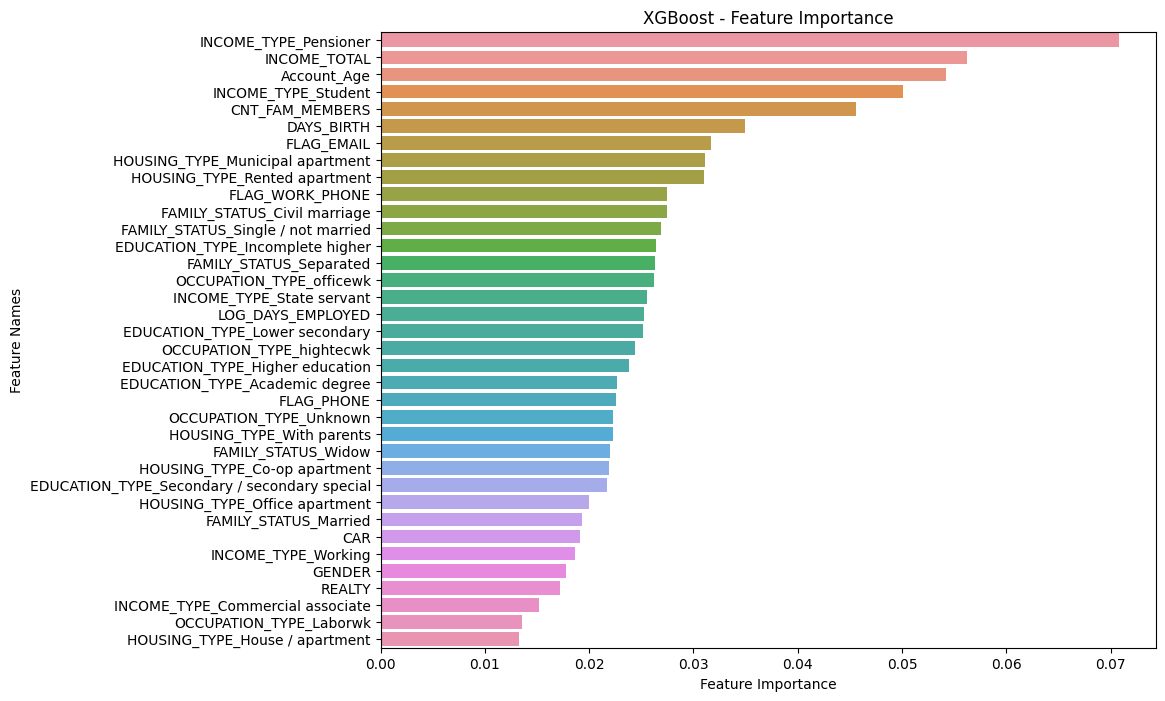

In [108]:
# Get feature importances
feature_importance_smotenc = xgb_smotenc3.feature_importances_

# Visualize feature importances
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    print(fi_df)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(feature_importance_smotenc, X_train_smotenc_ohe.columns, 'XGBoost')
plt.show()